### TC5035.10 Proyecto Integrador
 
Dra. Grettel Barceló Alonso
Dr. Luis Eduardo Falcón Morales

Liga Github: https://github.com/A01793499-DiegoGuerra/Proyecto-Integrador-Equipo18/tree/main

#### Equipo 18 : “Modelos para la Optimización de Precios en Estaciones de Autoservicio”

* Diego Fernando Guerra Burgos	A01793499
* Esteban Sánchez Retamoza		A01740631
* Hansel Zapiain Rodríguez		A00469031


**Avance 1. Análisis exploratorio de datos**
   
Abril 2024

**Objetivos**

2.1 Elegir las características más relevantes para reducir la dimensionalidad y aumentar la capacidad de generalización del modelo.

2.2 Abordar y corregir los problemas identificados en los datos.

**Instrucciones**

Este primer avance consiste en realizar un análisis exploratorio de datos (EDA - Exploratory Data Analysis), es decir, describir los datos utilizando técnicas estadísticas y de visualización (análisis univariante y bi/multivariante) para hacer enfoque en sus aspectos más relevantes, así como aplicar y justificar operaciones de preprocesamiento, relacionadas con el manejo de valores faltantes, atípicos y alta cardinalidad. Es importante que incluyan sus conclusiones del EDA, identificando tendencias o relaciones importantes.

Las siguientes son algunas de las preguntas comunes que podrán abordar a través del EDA:

¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia? 
¿Cuáles son las estadísticas resumidas del conjunto de datos?
¿Hay valores atípicos en el conjunto de datos?
¿Cuál es la cardinalidad de las variables categóricas?
¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?
¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).
¿Hay correlación entre las variables dependientes e independientes?
¿Cómo se distribuyen los datos en función de diferentes categorías?
¿Existen patrones o agrupaciones (clusters) en los datos con características similares?
¿Se deberían normalizar las imágenes para visualizarlas mejor?
¿Hay desequilibrio en las clases de la variable objetivo?
Deberán contar con un repositorio en GitHubLinks to an external site., para compartir los resultados con el equipo docente. 

***Importar Librerias***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import plotly.express as px
import random
import functools

from datetime_truncate import truncate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from deap import base, creator, tools, algorithms

In [2]:
%matplotlib inline

In [3]:
path = '98_Datasets/'# this needs to be changed to the directory of the excel files

***Consolidación de datos (Opcional)***

In [4]:
cost_files_db = [f'{path}Compras 2022 V2.xlsx', f'{path}Compras 2023 V2.xlsx', f'{path}Compras 2024 V2.xlsx']
df_cost = pd.DataFrame()

for file in cost_files_db:
    year_db_cost = pd.read_excel(file, skiprows = 4)
    df_cost = pd.concat([df_cost, year_db_cost], ignore_index = True)

df_cost.to_pickle(f'{path}base_compras_combinada_v2.pkl')


sales_files_db = [f'{path}Ventas 2022 V2.xlsx', f'{path}Ventas 2023 V2.xlsx', f'{path}Ventas 2024 V2.xlsx']
df_sales = pd.DataFrame()

for file in sales_files_db:
    year_db_sales = pd.read_excel(file, skiprows = 1)
    df_sales = pd.concat([df_sales, year_db_sales], ignore_index = True)

df_sales.to_pickle(f'{path}base_ventas_combinada_v2.pkl')

***Carga de Bases***

Para este proyecto tenemos 2 fuentes de información primarias que se obtuvieron directamente de los sistemas ERP del Grupo Golden

**Transacciones de Ventas**: Considera todos los despachos ejecutados en una gasolinera de grupo golden, incluyendo la distinción de volumenes de compra así como datos adicionales.

**Transacciones de Compra**: Considera todas las operaciones de compra de combustible para reabastecer a la gasolinera.

In [5]:
df_sales = pd.read_pickle(f'{path}base_ventas_combinada_v2.pkl')
df_sales.head()

Folio      Fecha      Hora  Posición  Cod.Externo  Producto  \
0  3042508-0 2022-01-01  00:11:00         4          1.0     MAGNA   
1  3042509-0 2022-01-01  00:18:00         3          2.0   PREMIUM   
2  3042510-0 2022-01-01  00:20:00         3          1.0     MAGNA   
3  3042511-0 2022-01-01  00:25:00         4          1.0     MAGNA   
4  3042512-0 2022-01-01  00:30:00         4          1.0     MAGNA   

   Precio de Venta del litro con impuestos  \
0                                    19.29   
1                                    22.49   
2                                    19.29   
3                                    19.29   
4                                    19.29   

   Precio de Venta del litro sin impuestos  I.E.P.S.       IVA  \
0                                15.824424    0.4514  3.014176   
1                                18.512424    0.4514  3.526176   
2                                15.824424    0.4514  3.014176   
3                                15.824424    0.4514  3.014176   
4                                15.824424    0.4514  3.014176   

   Venta Unidades   IVA total  IEPS Total  Venta sin impuestos  \
0           9.798   29.532896    4.422817           155.047706   
1          33.748  119.001388   15.233847           624.757285   
2           9.798   29.532896    4.422817           155.047706   
3          14.723   44.377713    6.645962           232.982995   
4           9.798   29.532896    4.422817           155.047706   

   Venta Ticket (con impuestos)  
0                     189.00342  
1                     758.99252  
2                     189.00342  
3                     284.00667  
4                     189.00342

In [6]:
df_purchases = pd.read_pickle(f'{path}base_compras_combinada_v2.pkl')
df_purchases.head()

Folio      Fecha      Hora        Tanque   Volumen  Precio Factura  \
0  3737260 2022-01-03  12:22:00   2 [1:MAGNA]  29644.12       582799.98   
1  3740687 2022-01-06  10:05:00  1 [3:DIESEL]  19417.05       381800.01   
2  3741826 2022-01-07  09:22:00   2 [1:MAGNA]  28198.25       570584.01   
3  3741848 2022-01-07  09:58:00   2 [1:MAGNA]  30200.52       570585.01   
4  3745298 2022-01-10  08:01:00   2 [1:MAGNA]  25639.59       504900.02   

         IVA F      IEPS F     Sin imp F  Por litro U Producto     IVA U  \
0  91113.62016  13339.8540  478346.50584    19.659885    MAGNA  3.073582   
1  59938.51224   7184.3085  314677.18926    19.663132   DIESEL  3.086901   
2  89263.16760  12689.2125  468631.62990    20.234731    MAGNA  3.165557   
3  89119.16416  13590.2340  467875.61184    18.893218    MAGNA  2.950915   
4  78937.95272  11537.8155  414424.25178    19.692203    MAGNA  3.078753   

    IEPS U  Sin imp U  
0     0.45  16.136303  
1     0.37  16.206231  
2     0.45  16.619174  
3     0.45  15.492303  
4     0.45  16.163451

***Información Básica Fuentes de Información***

Disponemos de una base de ventas de 15 variables. También tenemos dos variables (Fecha y Hora) las cuales deben ser cambiadas a formato DATETIME para poder analizar componentes temporales. En cuanto a la variable Posición, que es una variable categórica y tiene formato de una variable numérica, debe ser cambiada para reflejar el verdadero tipo de dato.

In [7]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888783 entries, 0 to 888782
Data columns (total 15 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Folio                                    888783 non-null  object        
 1   Fecha                                    888783 non-null  datetime64[ns]
 2   Hora                                     888783 non-null  object        
 3   Posición                                 888783 non-null  int64         
 4   Cod.Externo                              785767 non-null  float64       
 5   Producto                                 888720 non-null  object        
 6   Precio de Venta del litro con impuestos  888783 non-null  float64       
 7   Precio de Venta del litro sin impuestos  888783 non-null  float64       
 8   I.E.P.S.                                 888720 non-null  float64       
 9   IVA                       

In [8]:
df_sales.rename(columns = {'Folio':'folio_venta', 'Precio de Venta del litro con impuestos':'precio_bruto', 'Precio de Venta del litro sin impuestos':'precio_neto', 'Venta Ticket (con impuestos)':'venta_bruta', 'Venta sin impuestos':'venta_neta', 'Venta Unidades':'volumen_despachado', 'Producto':'producto'}, inplace = True)

Disponemos de una base de compras de 14 variables. También tenemos dos variables (Fecha y Hora) las cuales deben ser cambiadas a formato DATETIME para poder unir ambas bases. De la misma manera tenemos datos a nivel factura asi como nivel unitarios. Para determinar el margen bruto de cada operación de despacho, nuestro interes es el costo unitario del combustible por lo que los campos IVA F, IEPS F, Sin Imp F y Precio Factura los descartaremos del data frame más adelante. En cuanto a la variable Tanque, que es una variable categórica, debe ser eliminada del análisis dado que solo es un indicador de donde fue depositado el combustible por lo que no agregara valor al análisis más adelante

In [9]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Folio           685 non-null    int64         
 1   Fecha           685 non-null    datetime64[ns]
 2   Hora            685 non-null    object        
 3   Tanque          685 non-null    object        
 4   Volumen         685 non-null    float64       
 5   Precio Factura  684 non-null    float64       
 6   IVA F           685 non-null    float64       
 7   IEPS F          685 non-null    float64       
 8   Sin imp F       685 non-null    float64       
 9   Por litro U     685 non-null    float64       
 10  Producto        685 non-null    object        
 11  IVA U           685 non-null    float64       
 12   IEPS U         685 non-null    float64       
 13  Sin imp U       685 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(3)
memo

In [10]:
df_purchases.drop(['Precio Factura', 'IVA F', 'IEPS F', 'Sin imp F', 'Tanque'], axis = 1, inplace = True)
df_purchases.rename(columns = {'Folio':'folio_compra','Por litro U':'costo_bruto', 'Sin imp U':'costo_neto', 'Producto':'producto'}, inplace = True)

***Transformación de Bases***

Para consolidar las bases de datos es importante garantizar que todos los campos de fecha existentes sean los correctos. En los siguientes pasos se crearan las estampas de tiempo que nos permitiran hacer este proceso, de la misma manera nos garantizará que podamos hacer análisis de temporalidad hacia adelante. De la misma manera se eliminaran los campos de Fecha y Hora dado que todas las operaciones hacia adelante se buscaran hacer con la estampa de tiempo

In [11]:
df_sales['sale_date'] = pd.to_datetime(df_sales['Fecha'], errors = 'coerce', infer_datetime_format = True)
df_sales['sale_localtime'] = pd.to_timedelta(df_sales['Hora'].astype(str))
df_sales['sale_timeStamp'] = df_sales['sale_date'] + df_sales['sale_localtime']

df_sales.drop(['Fecha', 'Hora'], axis = 1, inplace = True)
df_sales.head()

/var/folders/hz/rf4k4thx75ng3j5rtm1h4wg80000gn/T/ipykernel_1056/2138479121.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_sales['sale_date'] = pd.to_datetime(df_sales['Fecha'], errors = 'coerce', infer_datetime_format = True)


folio_venta  Posición  Cod.Externo  producto  precio_bruto  precio_neto  \
0   3042508-0         4          1.0     MAGNA         19.29    15.824424   
1   3042509-0         3          2.0   PREMIUM         22.49    18.512424   
2   3042510-0         3          1.0     MAGNA         19.29    15.824424   
3   3042511-0         4          1.0     MAGNA         19.29    15.824424   
4   3042512-0         4          1.0     MAGNA         19.29    15.824424   

   I.E.P.S.       IVA  volumen_despachado   IVA total  IEPS Total  venta_neta  \
0    0.4514  3.014176               9.798   29.532896    4.422817  155.047706   
1    0.4514  3.526176              33.748  119.001388   15.233847  624.757285   
2    0.4514  3.014176               9.798   29.532896    4.422817  155.047706   
3    0.4514  3.014176              14.723   44.377713    6.645962  232.982995   
4    0.4514  3.014176               9.798   29.532896    4.422817  155.047706   

   venta_bruta  sale_date  sale_localtime      sale_timeStamp  
0    189.00342 2022-01-01 0 days 00:11:00 2022-01-01 00:11:00  
1    758.99252 2022-01-01 0 days 00:18:00 2022-01-01 00:18:00  
2    189.00342 2022-01-01 0 days 00:20:00 2022-01-01 00:20:00  
3    284.00667 2022-01-01 0 days 00:25:00 2022-01-01 00:25:00  
4    189.00342 2022-01-01 0 days 00:30:00 2022-01-01 00:30:00

In [12]:
df_purchases['purchase_date'] = pd.to_datetime(df_purchases['Fecha'], errors = 'coerce', infer_datetime_format = True)
df_purchases['purchase_localtime'] = pd.to_timedelta(df_purchases['Hora'].astype(str))
df_purchases['purchase_timeStamp'] = df_purchases['purchase_date'] + df_purchases['purchase_localtime']

df_purchases.drop(['Fecha', 'Hora'], axis = 1, inplace = True)
df_purchases.head()

/var/folders/hz/rf4k4thx75ng3j5rtm1h4wg80000gn/T/ipykernel_1056/3299460077.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_purchases['purchase_date'] = pd.to_datetime(df_purchases['Fecha'], errors = 'coerce', infer_datetime_format = True)


folio_compra   Volumen  costo_bruto producto     IVA U   IEPS U  \
0       3737260  29644.12    19.659885    MAGNA  3.073582     0.45   
1       3740687  19417.05    19.663132   DIESEL  3.086901     0.37   
2       3741826  28198.25    20.234731    MAGNA  3.165557     0.45   
3       3741848  30200.52    18.893218    MAGNA  2.950915     0.45   
4       3745298  25639.59    19.692203    MAGNA  3.078753     0.45   

   costo_neto purchase_date purchase_localtime  purchase_timeStamp  
0   16.136303    2022-01-03    0 days 12:22:00 2022-01-03 12:22:00  
1   16.206231    2022-01-06    0 days 10:05:00 2022-01-06 10:05:00  
2   16.619174    2022-01-07    0 days 09:22:00 2022-01-07 09:22:00  
3   15.492303    2022-01-07    0 days 09:58:00 2022-01-07 09:58:00  
4   16.163451    2022-01-10    0 days 08:01:00 2022-01-10 08:01:00

***Información datos faltantes o NA***

En este caso, los datos de venta principales como la fecha de transacción, cantidad de combustible, tipo de combustible, precio, entre otros, no registran valores faltantes. La gran mayoría de datos faltantes se observan en información del cliente como tipo de vehículo, el nombre, placas, etc. En este caso, los patrones de ausencia se deben a la falta de recolección o estandarización de este tipo de datos por parte de la gasolinera.

In [13]:
#Calculando data faltante en la base de datos por columna
missing_percentage_per_column_sales = (df_sales.isnull().mean() * 100).round(2)
print("Presencia de datos faltantes por dimensión (en porcentaje):")
print(missing_percentage_per_column_sales)

Presencia de datos faltantes por dimensión (en porcentaje):
folio_venta            0.00
Posición               0.00
Cod.Externo           11.59
producto               0.01
precio_bruto           0.00
precio_neto            0.00
I.E.P.S.               0.01
IVA                    0.00
volumen_despachado     0.00
IVA total              0.00
IEPS Total             0.00
venta_neta             0.00
venta_bruta            0.00
sale_date              0.00
sale_localtime         0.00
sale_timeStamp         0.00
dtype: float64


En este caso, los datos de compras principales como la fecha de transacción, cantidad de combustible, tipo de combustible, precio, entre otros, no registran valores faltantes. 

In [14]:
#Calculando data faltante en la base de datos por columna
missing_percentage_per_column_purchases = (df_purchases.isnull().mean() * 100).round(2)
print("Presencia de datos faltantes por dimensión (en porcentaje):")
print(missing_percentage_per_column_purchases)

Presencia de datos faltantes por dimensión (en porcentaje):
folio_compra          0.0
Volumen               0.0
costo_bruto           0.0
producto              0.0
IVA U                 0.0
 IEPS U               0.0
costo_neto            0.0
purchase_date         0.0
purchase_localtime    0.0
purchase_timeStamp    0.0
dtype: float64


***Unificación de Bases***

Usando las estampas de tiempo obtendremos el costo de reposición de cada despacho a cliente. Esto nos permitirá obtener un cálculo de margen bruto que al finalizar estará atado con nuestro objetivo final de optimización de precios

In [15]:
df_sales.sort_values(['producto', 'sale_date'], inplace = True)
df_purchases.sort_values(['producto', 'purchase_date'], inplace = True)

df_master = pd.DataFrame()

for product_type in df_sales['producto'].unique():

    sales_temp = df_sales[df_sales['producto'] == product_type]
    purchases_temp = df_purchases[df_purchases['producto'] == product_type]
    
    merged_temp = pd.merge_asof(sales_temp, purchases_temp, left_on = 'sale_date', right_on = 'purchase_date',
                                by = 'producto', direction = 'backward')

    # Append the result to the main DataFrame
    df_master = pd.concat([df_master, merged_temp], ignore_index = True)

df_master.head(5000)

folio_venta  Posición  Cod.Externo producto  precio_bruto  precio_neto  \
0      3042725-0        10          3.0   DIESEL         20.99    17.252424   
1      3042818-0        10          3.0   DIESEL         20.99    17.252424   
2      3042846-0         9          3.0   DIESEL         20.99    17.252424   
3      3043188-0        10          3.0   DIESEL         20.99    17.316852   
4      3043285-0        10          3.0   DIESEL         20.99    17.316852   
...          ...       ...          ...      ...           ...          ...   
4995   3171223-0        10          3.0   DIESEL         24.99    20.653668   
4996   3171252-0         9          3.0   DIESEL         24.99    20.653668   
4997   3171255-0         9          3.0   DIESEL         24.99    20.653668   
4998   3171365-0        10          3.0   DIESEL         24.99    20.653668   
4999   3171499-0         9          3.0   DIESEL         24.99    20.653668   

      I.E.P.S.       IVA  volumen_despachado    IVA total  ...  \
0       0.4514  3.286176              78.657   258.480746  ...   
1       0.4514  3.286176              13.721    45.089621  ...   
2       0.4514  3.286176              82.325   270.534439  ...   
3       0.3747  3.298448              15.912    52.484905  ...   
4       0.3747  3.298448              68.560   226.141595  ...   
...        ...       ...                 ...          ...  ...   
4995    0.4023  3.934032             381.610  1501.265952  ...   
4996    0.4023  3.934032               0.050     0.196702  ...   
4997    0.4023  3.934032               0.040     0.157361  ...   
4998    0.4023  3.934032              50.680   199.376742  ...   
4999    0.4023  3.934032               2.000     7.868064  ...   

          sale_timeStamp  folio_compra  Volumen costo_bruto    IVA U  IEPS U  \
0    2022-01-01 14:39:00           NaN      NaN         NaN      NaN     NaN   
1    2022-01-01 17:42:00           NaN      NaN         NaN      NaN     NaN   
2    2022-01-01 18:40:00           NaN      NaN         NaN      NaN     NaN   
3    2022-01-02 13:03:00           NaN      NaN         NaN      NaN     NaN   
4    2022-01-02 14:49:00           NaN      NaN         NaN      NaN     NaN   
...                  ...           ...      ...         ...      ...     ...   
4995 2022-04-23 20:55:00     3864889.0  9697.17   24.336997  3.83472    0.37   
4996 2022-04-23 21:12:00     3864889.0  9697.17   24.336997  3.83472    0.37   
4997 2022-04-23 21:12:00     3864889.0  9697.17   24.336997  3.83472    0.37   
4998 2022-04-24 00:25:00     3864889.0  9697.17   24.336997  3.83472    0.37   
4999 2022-04-24 08:43:00     3864889.0  9697.17   24.336997  3.83472    0.37   

      costo_neto  purchase_date  purchase_localtime  purchase_timeStamp  
0            NaN            NaT                 NaT                 NaT  
1            NaN            NaT                 NaT                 NaT  
2            NaN            NaT                 NaT                 NaT  
3            NaN            NaT                 NaT                 NaT  
4            NaN            NaT                 NaT                 NaT  
...          ...            ...                 ...                 ...  
4995   20.132278     2022-04-22     0 days 11:44:00 2022-04-22 11:44:00  
4996   20.132278     2022-04-22     0 days 11:44:00 2022-04-22 11:44:00  
4997   20.132278     2022-04-22     0 days 11:44:00 2022-04-22 11:44:00  
4998   20.132278     2022-04-22     0 days 11:44:00 2022-04-22 11:44:00  
4999   20.132278     2022-04-22     0 days 11:44:00 2022-04-22 11:44:00  

[5000 rows x 25 columns]

***Información Básica Data Frame***

In [16]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888720 entries, 0 to 888719
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   folio_venta         888720 non-null  object         
 1   Posición            888720 non-null  int64          
 2   Cod.Externo         785767 non-null  float64        
 3   producto            888720 non-null  object         
 4   precio_bruto        888720 non-null  float64        
 5   precio_neto         888720 non-null  float64        
 6   I.E.P.S.            888720 non-null  float64        
 7   IVA                 888720 non-null  float64        
 8   volumen_despachado  888720 non-null  float64        
 9   IVA total           888720 non-null  float64        
 10  IEPS Total          888720 non-null  float64        
 11  venta_neta          888720 non-null  float64        
 12  venta_bruta         888720 non-null  float64        
 13  sale_date     

In [17]:
df_sales.describe()

Posición   Cod.Externo   precio_bruto    precio_neto  \
count  888783.000000  785767.00000  888783.000000  888783.000000   
mean        4.469676       1.18409      21.337248      17.510346   
min         1.000000       1.00000       0.000000       0.000000   
25%         3.000000       1.00000      20.490000      16.832424   
50%         4.000000       1.00000      21.190000      17.392452   
75%         6.000000       1.00000      21.990000      18.032700   
max        13.000000       3.00000      25.990000      21.493668   
std         2.337038       0.50755       1.259953       1.046974   

            I.E.P.S.            IVA  volumen_despachado     IVA total  \
count  888720.000000  888783.000000        8.887830e+05  8.887830e+05   
mean        0.491633       3.335304        5.714201e+01  1.914115e+02   
min         0.374700       0.000000        0.000000e+00  0.000000e+00   
25%         0.484700       3.206176        7.140000e+00  2.342525e+01   
50%         0.484700       3.312848        1.000000e+01  3.312848e+01   
75%         0.522500       3.434800        2.196300e+01  7.458539e+01   
max         0.637500       4.094032        3.341517e+07  1.106994e+08   
std         0.040695       0.199424        3.547829e+04  1.175616e+05   

         IEPS Total    venta_neta   venta_bruta  \
count  8.887830e+05  8.887830e+05  8.887830e+05   
mean   2.752536e+01  1.004911e+03  1.223852e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.509228e+00  1.229826e+02  1.499250e+02   
50%    4.897894e+00  1.739245e+02  2.119000e+02   
75%    1.110496e+01  3.915733e+02  4.777805e+02   
max    1.619633e+07  5.811717e+08  7.080675e+08   
std    1.719119e+04  6.171985e+05  7.519500e+05   

                           sale_date             sale_localtime  \
count                         888783                     888783   
mean   2023-02-04 17:29:32.203564032  0 days 14:01:43.514941217   
min              2022-01-01 00:00:00            0 days 00:00:00   
25%              2022-07-08 00:00:00            0 days 09:57:00   
50%              2023-01-21 00:00:00            0 days 14:15:00   
75%              2023-08-28 00:00:00            0 days 18:01:00   
max              2024-04-30 00:00:00            0 days 23:59:00   
std                              NaN  0 days 04:53:55.206477320   

                      sale_timeStamp  
count                         888783  
mean   2023-02-05 07:31:15.718504960  
min              2022-01-01 00:11:00  
25%              2022-07-08 19:40:00  
50%              2023-01-21 00:03:00  
75%              2023-08-28 19:41:30  
max              2024-04-30 23:54:00  
std                              NaN

***Estadísticas de las variables***

In [18]:
unique_values_per_column = df_master.nunique()
unique_values_per_column

folio_venta           888720
Posición                  13
Cod.Externo                3
producto                   3
precio_bruto              30
precio_neto               58
I.E.P.S.                   9
IVA                       58
volumen_despachado     25632
IVA total              82317
IEPS Total             57832
venta_neta             82316
venta_bruta            77722
sale_date                851
sale_localtime          1440
sale_timeStamp        565170
folio_compra             596
Volumen                  499
costo_bruto              595
IVA U                    595
 IEPS U                    3
costo_neto               595
purchase_date            450
purchase_localtime       409
purchase_timeStamp       596
dtype: int64

In [19]:
print('Identificación de manguera dispensadora:')
print(df_master['Posición'].value_counts())

Identificación de manguera dispensadora:
Posición
4     173808
2     130734
6     124458
3     115470
5      87812
1      83450
8      69633
7      56350
10     25251
9      21736
11        10
12         7
13         1
Name: count, dtype: int64


In [20]:
print('Tipo de Combustible vendido:')
print(df_master['producto'].value_counts())

Tipo de Combustible vendido:
producto
 MAGNA      766167
 PREMIUM     75549
 DIESEL      47004
Name: count, dtype: int64


***Presencia de valores atípicos***

Nuestras variables numéricas son Volumen, Precio Neto, Precio Bruto, Costo Neto, Costo Bruto, Venta Bruta. En estos gráficos de Caja y Densidad podemos observar la presencia de valores atípicos en Cantidad e Importe. Estos datos atípicos reflejan valores demasiado altos, lo cual resulta en que exista una distribución sesgada a la izquierda. Se debería eliminar estos registros para observar la nueva distribución.

En el caso de Precio, podemos observar que existe una distribución ligeramente sesgada a la izquierda, con la presencia de pocos valores atípicos, pero que se encuentran en valores lógicos, a comparación de los valores atípicos en las otras variables.

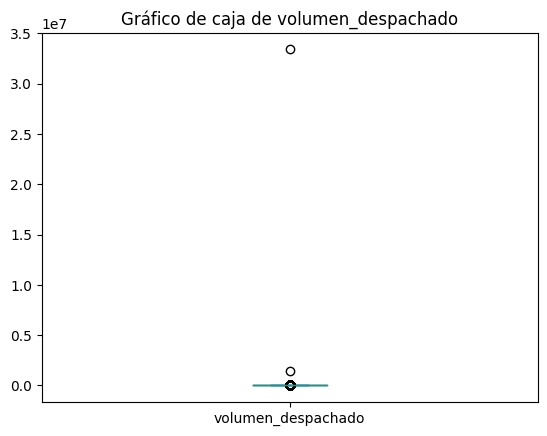

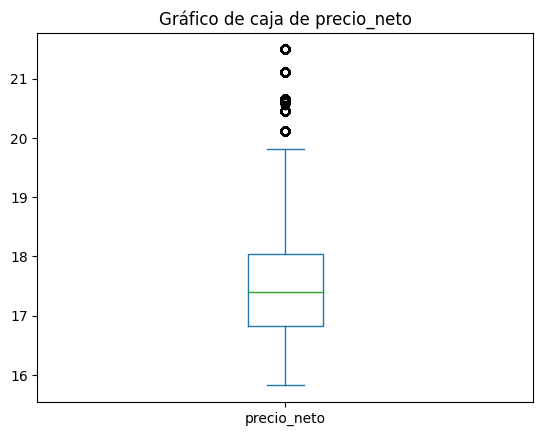

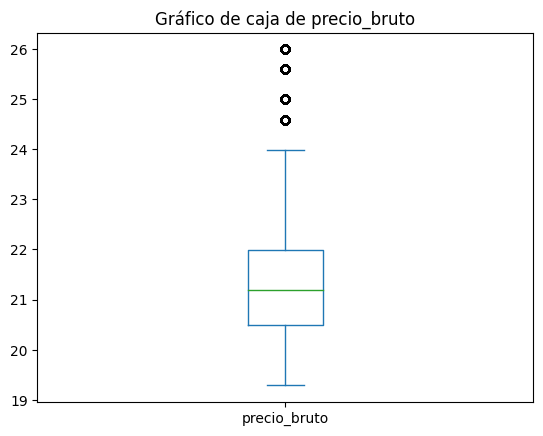

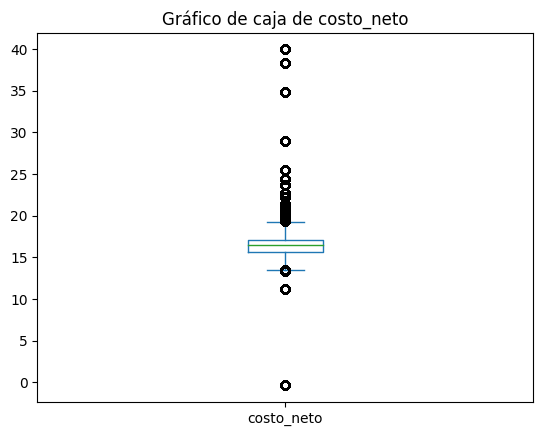

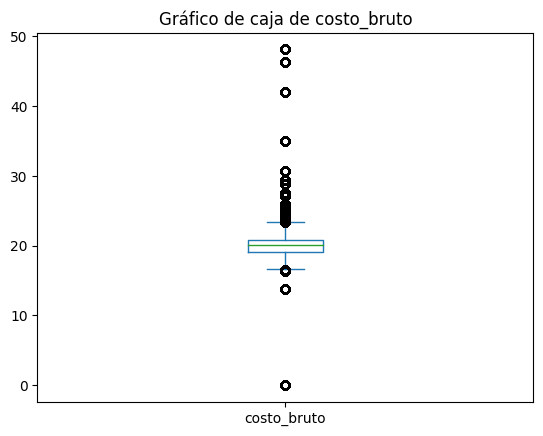

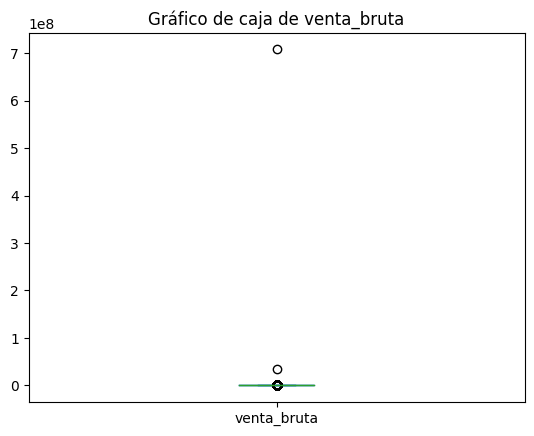

In [21]:
columnas_numericas = ['volumen_despachado', 'precio_neto', 'precio_bruto', 'costo_neto', 'costo_bruto','venta_bruta']

for column in columnas_numericas:
    plt.figure()
    df_master[column].plot(kind = 'box')
    plt.title(f'Gráfico de caja de {column}')
    plt.show()

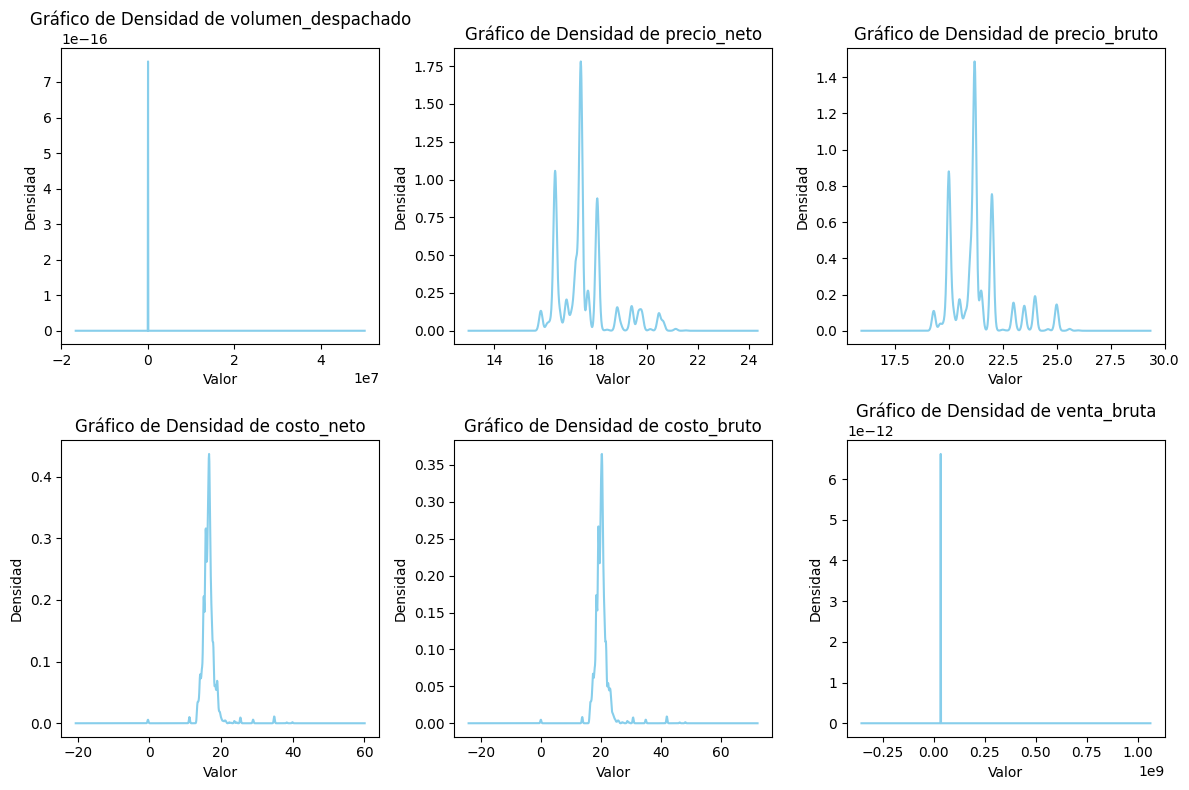

In [22]:
plt.figure(figsize = (12, 8))

for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    df_master[columna].plot(kind = 'density', color = 'skyblue')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')
    plt.title(f'Gráfico de Densidad de {columna}')

plt.tight_layout()
plt.show()

***Tratamiento de valores atípicos***

En este caso podemos observar que existen valores atípicos que tal vez son producto de mal registro por parte de la Gasolinera, lo que resulta en valores demasiado altos. Por ejemplo, el valor máximo de *Cantidad* se ubica en 6 millones de galones por una sola venta (un vehículo promedio se llena con 12 galones). Por lo cual para filtrar estos datos atípicos, vamos a eliminar, solamente para este análisis exploratorio, el 10% de los datos más altos de la serie de *Cantidad*.

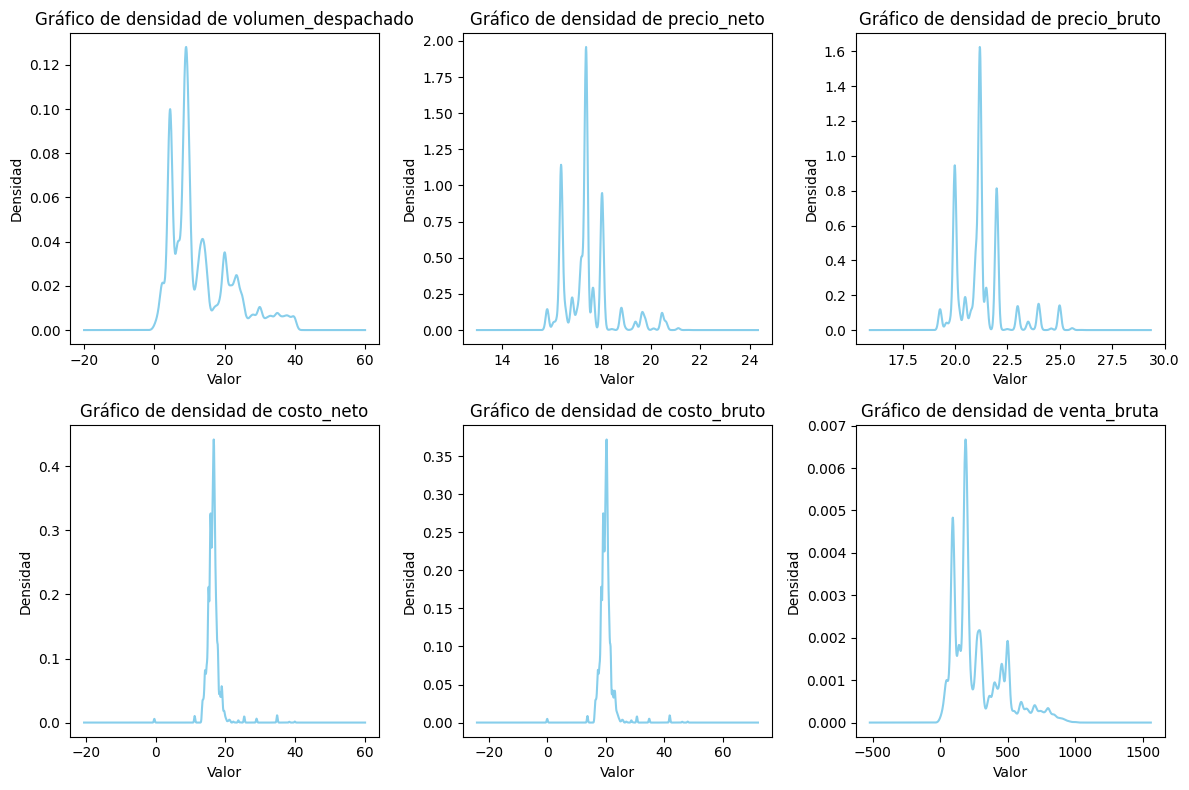

In [23]:
df_master_filter = df_master[df_master['volumen_despachado'] <= df_master['volumen_despachado'].quantile(0.90)].copy()

plt.figure(figsize = (12, 8))

for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 3, i)
    df_master_filter[columna].plot(kind = 'density', color = 'skyblue')
    plt.xlabel('Valor')
    plt.ylabel('Densidad')
    plt.title(f'Gráfico de densidad de {columna}')

plt.tight_layout()
plt.show()

Una vez que filtramos los datos atípicos, observamos que las variables *Cantidad* e *Importe*, tienen una distribución similar, con un ligero sesgo a la izquierda. De la misma manera aprovecharemos para eliminar todos aquellos valores que no tengan datos faltantes. De la misma manera normalizamos a nivel hora dado que esto nos permitirá hacer un mejor análisis hacia adelante

In [24]:
df_master_filter.reset_index(drop = True, inplace = True)
df_master_filter.drop('Cod.Externo', axis = 1, inplace = True)
df_master_filter.dropna(axis = 0 , inplace = True)

In [25]:
df_master_filter['sale_timeStamp'] = df_master_filter['sale_timeStamp'].dt.floor('h')

In [26]:
pmap = {' DIESEL':'diesel', ' MAGNA':'magna', ' PREMIUM':'premium'}
df_master_filter['producto'] = df_master_filter['producto'].map(pmap)

In [27]:
df_master_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801899 entries, 50 to 803387
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   folio_venta         801899 non-null  object         
 1   Posición            801899 non-null  int64          
 2   producto            801899 non-null  object         
 3   precio_bruto        801899 non-null  float64        
 4   precio_neto         801899 non-null  float64        
 5   I.E.P.S.            801899 non-null  float64        
 6   IVA                 801899 non-null  float64        
 7   volumen_despachado  801899 non-null  float64        
 8   IVA total           801899 non-null  float64        
 9   IEPS Total          801899 non-null  float64        
 10  venta_neta          801899 non-null  float64        
 11  venta_bruta         801899 non-null  float64        
 12  sale_date           801899 non-null  datetime64[ns] 
 13  sale_localtime    

In [28]:
df_master_filter.to_pickle(f'{path}base_master.pkl')

**Conclusiones Avance 1**

Para este análisis de la base de datos de nuestro Proyecto de Modelo para Optimización de Precios en Estaciones de Autoservicio tomamos como referencia la base diaria de ventas para el periodo 2022-2024 (abril). En primer lugar, consolidamos las bases de datos asegurándonos que cumplan con el tipo de dato correspondiente a la naturaleza de cada variable para poder analizar el contenido de la base de datos. 

Las variables completas hacen referencia a información de la transacción de Ventas de 1 gasolinera, en la cual encontramos 3 variables numéricas, 2 variables categóricas, 2 variables que hacen referencia a la fecha de la transacción y 1 variable de identificación de la transacción. 
Encontramos valores atípicos que pueden deberse a una incorrecta digitación de la información (por ejemplo, una venta fue de 6 millones de galones) por lo cual decidimos filtrar el 10% de los valores más altos de la variable Cantidad para poder realizar el análisis exploratorio. 

**Avance 2.Ingeniería de características**
    
Mayo 2024

**Objetivos**
    
2.3 Crear nuevas características para mejorar el rendimiento de los modelos.

2.4 Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.

**Instrucciones**

En esta fase, conocida como ingeniería de características (FE - Feature Engineering):

Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático. El procesamiento puede incluir:
Generación de nuevas características
Discretización o binning
Codificación (ordinal, one hot,…)
Escalamiento (normalización, estandarización, min – max,…)
Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)
* Todas las decisiones y técnicas empleadas deben ser justificadas.


Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. Los ejemplos siguientes son ilustrativos, pero no exhaustivos, de lo que se podría aplicar:
Umbral de varianza
Correlación
Chi-cuadrado
ANOVA
Análisis de componentes principales (PCA)
Análisis factorial (FA)
* Es necesario fundamentar los métodos ejecutados.

Incluir conclusiones de la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML.

***Análisis básico***

In [29]:
df_master_filter = pd.read_pickle(f'{path}base_master.pkl')

In [30]:
def date_info(df_interest, timeStamp): 
    df_interest['hour'] = df_interest[timeStamp].dt.hour
    df_interest['month'] = df_interest[timeStamp].dt.month
    df_interest['year'] = df_interest[timeStamp].dt.year
    df_interest['dow_n'] = df_interest[timeStamp].dt.dayofweek
    
    dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    
    df_interest['dow'] = df_interest['dow_n'].map(dmap)
    df_interest['clean_date'] = df_interest[timeStamp].dt.floor('D')

    return df_interest

In [31]:
df_alt = df_master_filter.copy()
df_alt = date_info(df_alt,'sale_timeStamp')

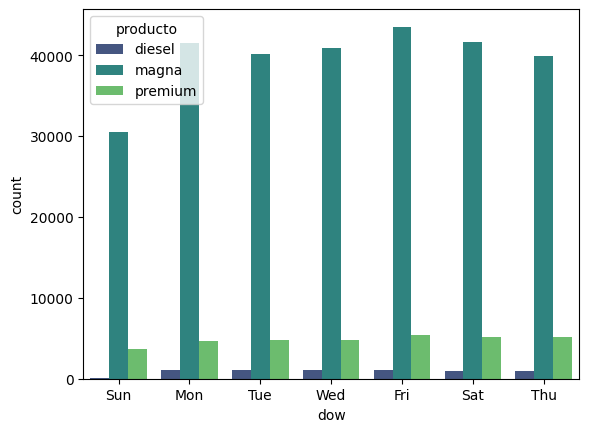

In [32]:
sns.countplot(x = 'dow', hue = 'producto', data = df_alt[df_alt['year'] == 2023], palette = 'viridis')
plt.show()

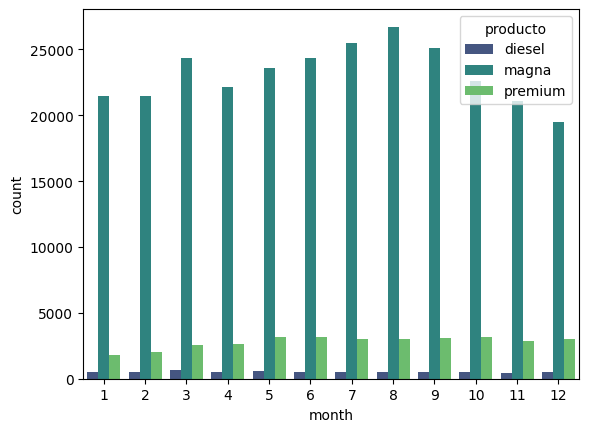

In [33]:
sns.countplot(x = 'month', hue = 'producto', data = df_alt[df_alt['year'] == 2023], palette = 'viridis')
plt.show()

***Transformación de datos para procesamiento por fecha***

Dado que estaremos trabajando con análisis de regresión para estimar demandas es necesario construir todas las estampas de manera que nos permita identificar patrones de demanda específicos (i.e. temporalidades). Es por esto que tenemos que generar un proceso de sumarización, además de asegurar que tenemos datos para la frecuencia mínima decidida (i.e. día hora) dentro los dataframes. De la misma manera se calcula el margen bruto para futuros análisis. 

In [34]:
df_master_summary = df_master_filter.groupby(by = ['producto','sale_timeStamp']).agg({
    'precio_bruto' : [('precio_bruto', 'mean')],
    'precio_neto' : [('precio_neto', 'mean')],
    'volumen_despachado' : [('volumen_despachado', 'sum'),('transaction_num', 'count')],
    'venta_neta' : [('venta_neta', 'sum')],
    'venta_bruta' : [('venta_bruta', 'sum')],
    'costo_bruto' : [('costo_bruto', 'mean')],
    'costo_neto' : [('costo_neto', 'mean')],
    'purchase_timeStamp' : [('purchase_timeStamp', 'min')]
}).reset_index()
df_master_summary.columns = [col[1] if col[1] else col[0] for col in df_master_summary.columns.values]

In [35]:
df_master_summary['margen_bruto'] = df_master_summary['venta_bruta'] - df_master_summary['costo_bruto'] * df_master_summary['volumen_despachado']
df_master_summary['margen_neto'] = df_master_summary['venta_neta'] - df_master_summary['costo_neto'] * df_master_summary['volumen_despachado']

In [36]:
df_master_summary.head()

producto      sale_timeStamp  precio_bruto  precio_neto  volumen_despachado  \
0   diesel 2022-01-06 06:00:00         20.99    17.316852             130.952   
1   diesel 2022-01-06 07:00:00         20.99    17.316852              31.014   
2   diesel 2022-01-06 08:00:00         20.99    17.316852              36.370   
3   diesel 2022-01-06 09:00:00         20.99    17.316852               7.527   
4   diesel 2022-01-06 10:00:00         20.99    17.316852              59.830   

   transaction_num   venta_neta  venta_bruta  costo_bruto  costo_neto  \
0                5  2267.676403   2748.68248    19.663132   16.206231   
1                2   537.064848    650.98386    19.663132   16.206231   
2                1   629.813907    763.40630    19.663132   16.206231   
3                1   130.343945    157.99173    19.663132   16.206231   
4                2  1036.067255   1255.83170    19.663132   16.206231   

   purchase_timeStamp  margen_bruto  margen_neto  
0 2022-01-06 10:05:00    173.756067   145.438098  
1 2022-01-06 10:05:00     41.151496    34.444813  
2 2022-01-06 10:05:00     48.258203    40.393301  
3 2022-01-06 10:05:00      9.987338     8.359648  
4 2022-01-06 10:05:00     79.386535    66.448480

In [37]:
start_date = df_master_summary['sale_timeStamp'].min()
end_date = df_master_summary['sale_timeStamp'].max()

all_dates = pd.date_range(start = start_date, end = end_date, freq = 'h')

In [38]:
def process_product_type(product_type):
    product_df = df_master_summary[df_master_summary['producto'] == product_type]
    product_df = product_df.set_index('sale_timeStamp').reindex(all_dates).rename_axis('sale_timeStamp').reset_index()
   
    product_df['precio_bruto'] = product_df['precio_bruto'].ffill()
    product_df['precio_neto'] = product_df['precio_neto'].ffill()
    
    product_df['costo_bruto'] = product_df['costo_bruto'].ffill()
    product_df['costo_neto'] = product_df['costo_neto'].ffill()

    product_df['purchase_timeStamp'] = product_df['purchase_timeStamp'].ffill()
    
    product_df['venta_neta'] = product_df['venta_neta'].fillna(0)
    product_df['venta_bruta'] = product_df['venta_bruta'].fillna(0)

    product_df['volumen_despachado'] = product_df['volumen_despachado'].fillna(0)
    product_df['transaction_num'] = product_df['transaction_num'].fillna(0)
    product_df['margen_bruto'] = product_df['margen_bruto'].fillna(0)
    product_df['margen_neto'] = product_df['margen_neto'].fillna(0)

    product_df['precio_bruto'] = product_df['precio_bruto'].fillna(0)
    product_df['precio_neto'] = product_df['precio_neto'].fillna(0)
    
    product_df['costo_bruto'] = product_df['costo_bruto'].fillna(0)
    product_df['costo_neto'] = product_df['costo_neto'].fillna(0)

    product_df['purchase_timeStamp'] = product_df['purchase_timeStamp'].fillna(start_date)
    
    product_df['producto'] = product_type
    
    return product_df

In [39]:
product_types = df_master_summary['producto'].unique()
product_dfs = {ptype: process_product_type(ptype) for ptype in product_types}

In [40]:
df_magna = product_dfs['magna']
df_premium = product_dfs['premium']
df_diesel = product_dfs['diesel']

In [41]:
df_product_time = pd.concat([df_magna, df_premium,df_diesel], ignore_index = True)
df_product_time = date_info(df_product_time,'sale_timeStamp')

In [42]:
df_product_time.head()

sale_timeStamp producto  precio_bruto  precio_neto  volumen_despachado  \
0 2022-01-03 00:00:00    magna         19.29    15.824424              34.214   
1 2022-01-03 01:00:00    magna         19.29    15.824424              47.537   
2 2022-01-03 02:00:00    magna         19.29    15.824424              61.741   
3 2022-01-03 03:00:00    magna         19.29    15.824424               4.769   
4 2022-01-03 04:00:00    magna         19.29    15.824424              14.256   

   transaction_num  venta_neta  venta_bruta  costo_bruto  costo_neto  \
0              5.0  541.416843    659.98806    19.659885   16.136303   
1              5.0  752.245644    916.98873    19.659885   16.136303   
2              6.0  977.015762   1190.98389    19.659885   16.136303   
3              1.0   75.466678     91.99401    19.659885   16.136303   
4              2.0  225.592989    274.99824    19.659885   16.136303   

   purchase_timeStamp  margen_bruto  margen_neto  hour  month  year  dow_n  \
0 2022-01-03 12:22:00    -12.655234   -10.670632     0      1  2022      0   
1 2022-01-03 12:22:00    -17.583207   -14.825797     1      1  2022      0   
2 2022-01-03 12:22:00    -22.837049   -19.255728     2      1  2022      0   
3 2022-01-03 12:22:00     -1.763980    -1.487351     3      1  2022      0   
4 2022-01-03 12:22:00     -5.273076    -4.446149     4      1  2022      0   

   dow clean_date  
0  Mon 2022-01-03  
1  Mon 2022-01-03  
2  Mon 2022-01-03  
3  Mon 2022-01-03  
4  Mon 2022-01-03

***Análisis de Temporalidad General***

En esta sección se analizó de manera general si existe un patrón de demanda en algún periodo en particular. Parte de los hallagazgos fueron que la demanda de la gasolina magna ha disminuido significativamente desde finales de 2022, mientras que la venta del combustible PREMIUM muestra una ligera tendencia creciente en el mismo periodo. Esto genera una incógnita sobre si esta caida obedece a un cámbio en la dinámica de precios o si se debe a un competidor nuevo cercano a dicha sucursal o un factor exógeno del que el equipo no tenga conocimiento.

In [43]:
df_timeseries = df_product_time[['clean_date', 'hour', 'month', 'year', 'dow', 'volumen_despachado', 'producto','transaction_num']]

In [44]:
grouped_date = df_timeseries.groupby(by = ['clean_date', 'producto']).sum().reset_index()
grouped_dayHour = df_timeseries.drop('clean_date', axis = 1).groupby(by = ['dow', 'hour']).sum()['transaction_num'].unstack()
grouped_dayMonth = df_timeseries.drop('clean_date', axis = 1).groupby(by = ['dow', 'month']).sum()['transaction_num'].unstack()

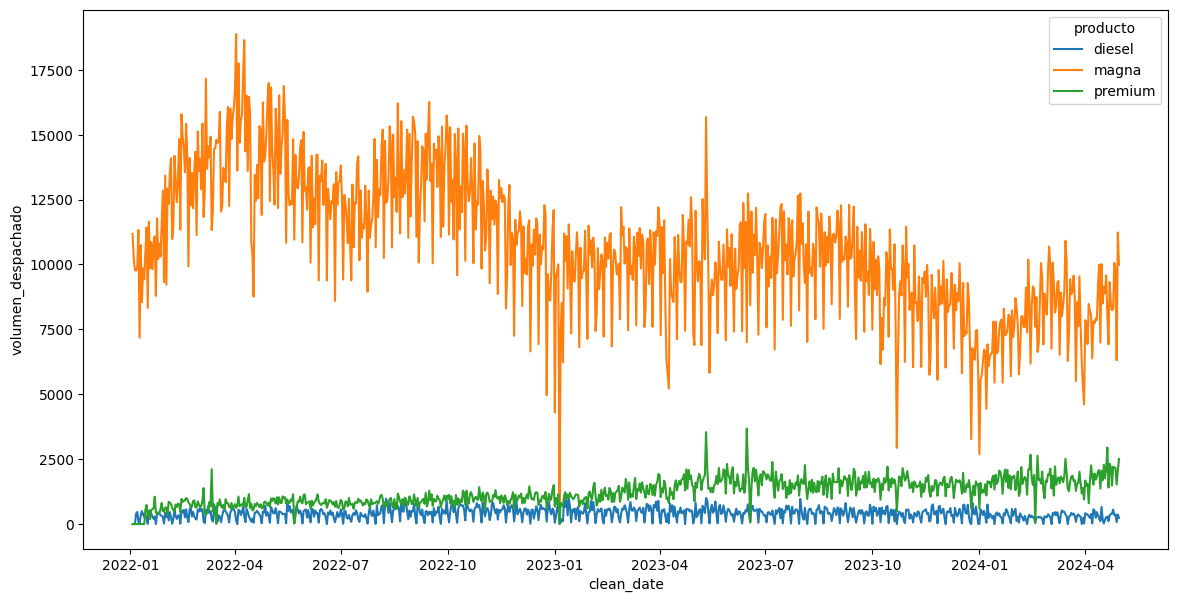

In [45]:
plt.figure(figsize = (14, 7))
sns.lineplot(data = grouped_date, x = 'clean_date', y = 'volumen_despachado', hue = 'producto')
plt.show()

En general se puede observa que no existe actividad significativa los días domingos en esta sucursal lo cuál hace mucho sentido dado que es una sucursal que se encuentra al costado de una carretera que generalmente tiene la mayoría de su tráfico entre semana.

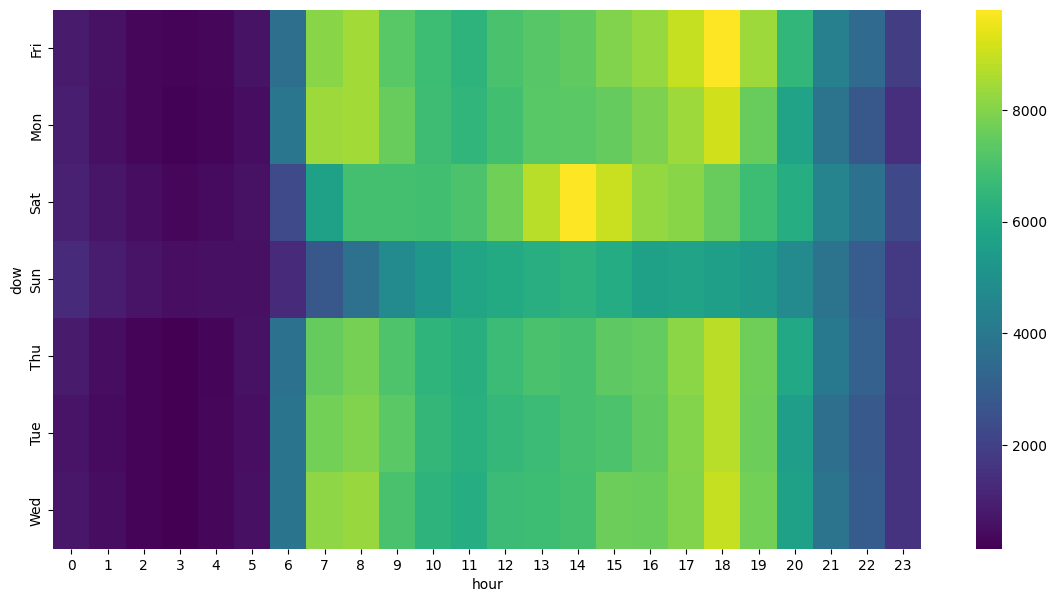

In [46]:
plt.figure(figsize = (14,7))
sns.heatmap(grouped_dayHour, cmap = 'viridis')
plt.show()

<Figure size 1400x700 with 0 Axes>

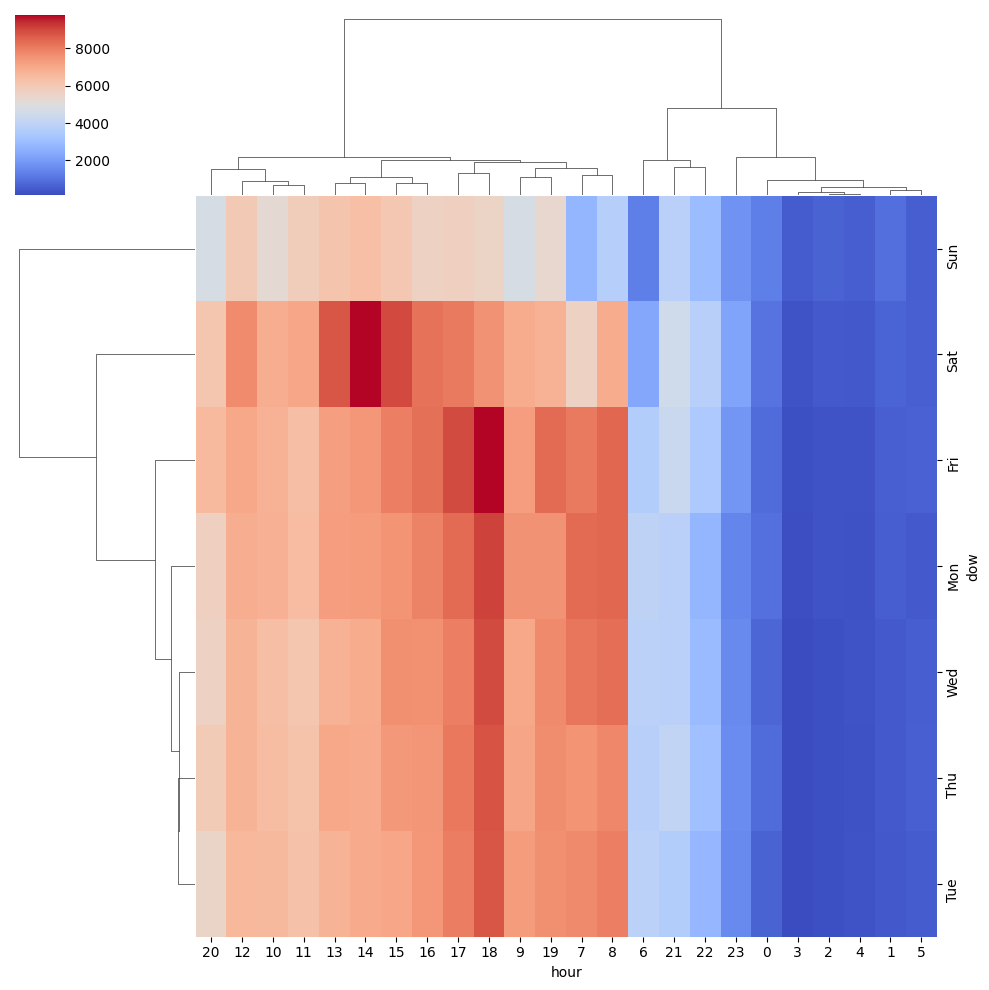

In [47]:
plt.figure(figsize = (14,7))
sns.clustermap(grouped_dayHour, cmap = 'coolwarm', method = 'centroid')
plt.show()

De la misma manera se puede observar que los primeros meses del año son aquellos que existe más tráfico en la sucursal.

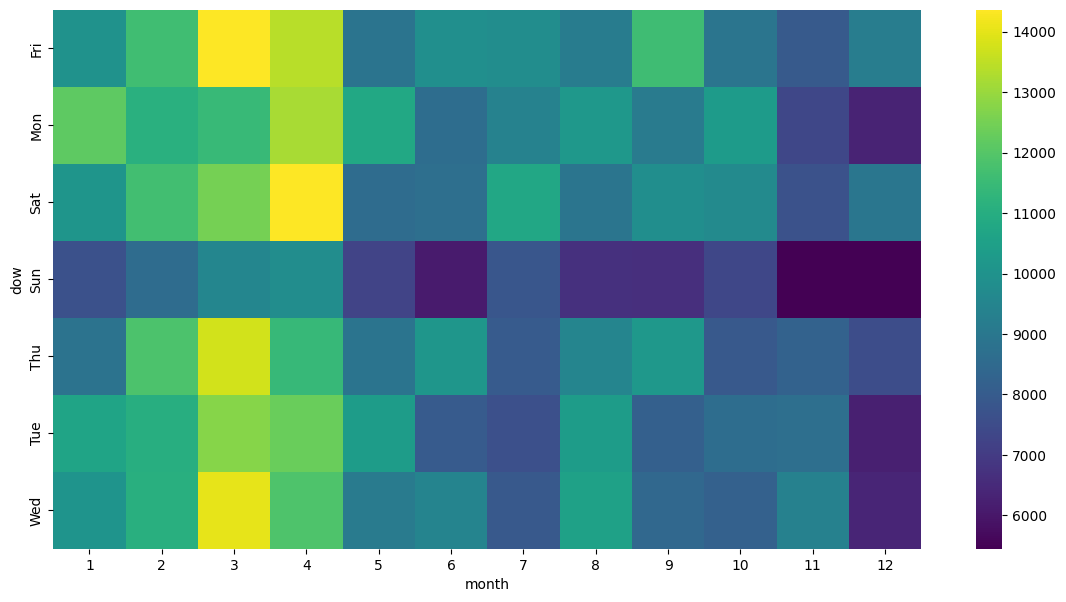

In [48]:
plt.figure(figsize = (14,7))
sns.heatmap(grouped_dayMonth, cmap = 'viridis')
plt.show()

<Figure size 1400x700 with 0 Axes>

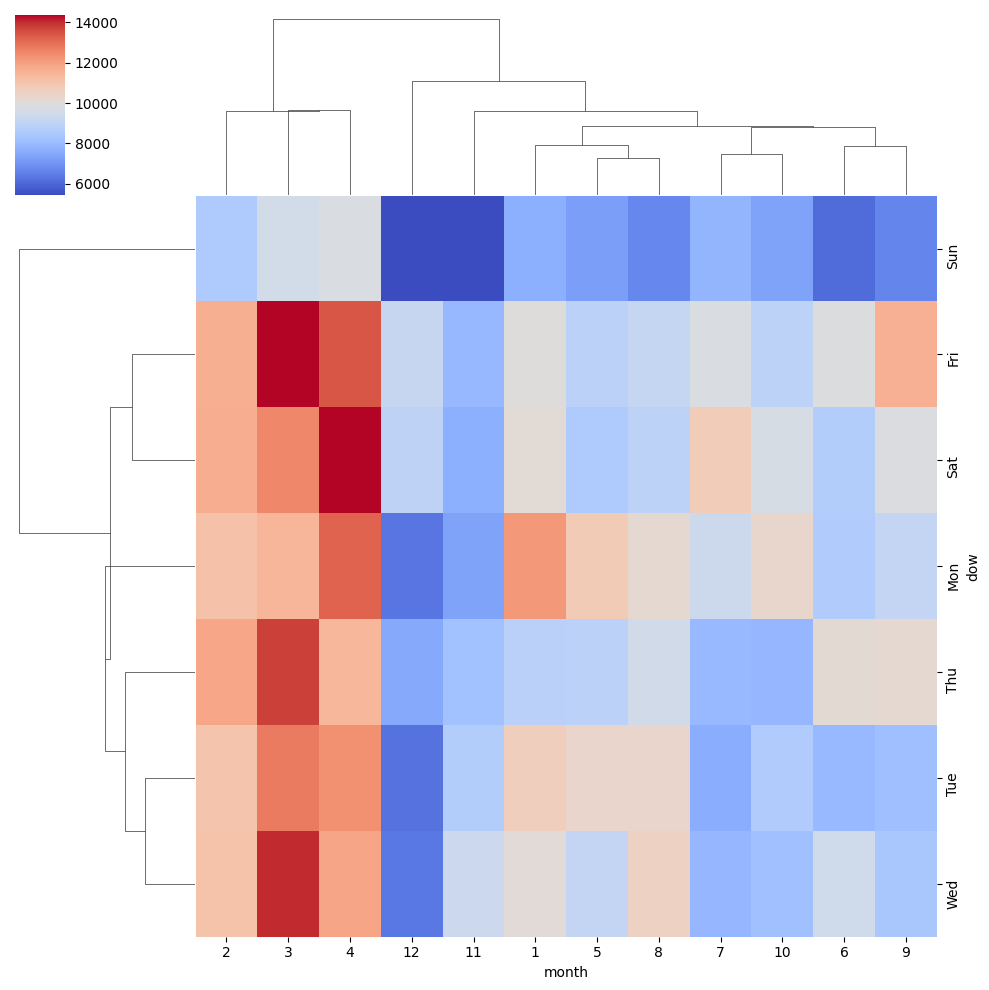

In [49]:
plt.figure(figsize = (14,7))
sns.clustermap(grouped_dayMonth, cmap = 'coolwarm', method = 'centroid')
plt.show()

***Análisis de Demanda***

A continuación se incluyen los componentes de demanda que nos permitirán decidir un modelo de predicción de demanda para cada uno de los productos que existen (Magna, Premium y Diesel). Estos factores son tendencia, temporalidad y residuales y nos ayudaran a identificar si existen ciclos continuos de demanda que faciliten el entrenamiento de nuestros algorítmos. Dentro de cada uno de los productos se puede visualizar que hay un alto componente de temporalidad que se tiene que considerar a la hora de construir el modelo, lo que es un indicativo que requeriremos los diferentes niveles de las estampas de tiempo (Hora, Dia, Mes).

In [50]:
df_magna.set_index('sale_timeStamp', inplace = True)
df_magna.sort_index(inplace = True)
df_premium.set_index('sale_timeStamp', inplace = True)
df_premium.sort_index(inplace = True)
df_diesel.set_index('sale_timeStamp', inplace = True)
df_diesel.sort_index(inplace = True)

#daily_magna_df = df_magna['Volumen despachado'].resample('D').sum()
#daily_premium_df = df_premium['Volumen despachado'].resample('D').sum() 
#daily_diesel_df = df_diesel['Volumen despachado'].resample('D').sum() 

***Análisis de Demanda Magna***

In [51]:
if not isinstance(df_magna.index, pd.DatetimeIndex):
    df_magna.index = pd.to_datetime(df_magna.index)

print("Start date:", df_magna.index[0])
print("End date:", df_magna.index[-1])
print("Number of data points:", len(df_magna))

if df_magna.index[0] <= pd.Timestamp.max - pd.DateOffset(days = len(df_magna)):
    if not df_magna.index.freq:
        df_magna.index.freq = 'h'

Start date: 2022-01-03 00:00:00
End date: 2024-04-30 23:00:00
Number of data points: 20376


/var/folders/hz/rf4k4thx75ng3j5rtm1h4wg80000gn/T/ipykernel_1056/1993943713.py:8: UserWarning: Discarding nonzero nanoseconds in conversion.
  if df_magna.index[0] <= pd.Timestamp.max - pd.DateOffset(days = len(df_magna)):


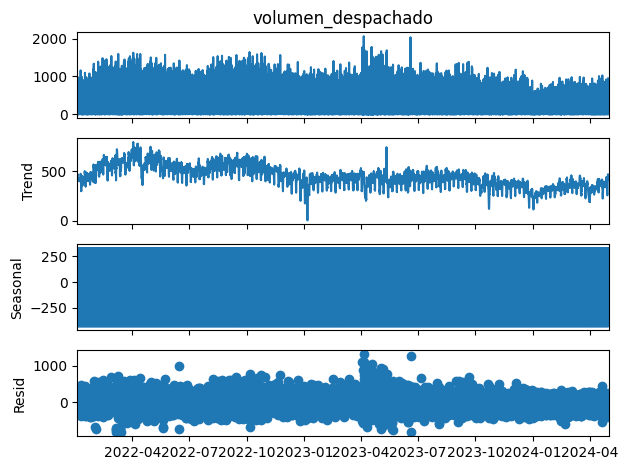

In [52]:
decomposition_magna = sm.tsa.seasonal_decompose(df_magna['volumen_despachado'], model = 'additive')

trend_magna = decomposition_magna.trend
seasonal_magna = decomposition_magna.seasonal
residual_magna = decomposition_magna.resid

fig = decomposition_magna.plot()
plt.show()

In [53]:
fig = px.line(x = df_magna['volumen_despachado'].index, y = seasonal_magna, labels={'y': 'Seasonality', 'x': 'Date'}, title = 'Seasonality Component')
fig.show()

In [54]:
print("Statistical Summary of Trend Component:")
print(trend_magna.describe())

print("\nStatistical Summary of Seasonal Component:")
print(seasonal_magna.describe())

print("\nStatistical Summary of Residual Component:")
print(residual_magna.describe())

Statistical Summary of Trend Component:
count    20352.000000
mean       445.416096
std        106.556749
min          2.196792
25%        373.278781
50%        438.623552
75%        517.019766
max        791.865625
Name: trend, dtype: float64

Statistical Summary of Seasonal Component:
count    2.037600e+04
mean    -9.384632e-15
std      2.891621e+02
min     -4.293881e+02
25%     -3.376257e+02
50%      1.723236e+02
75%      2.505608e+02
max      3.285681e+02
Name: seasonal, dtype: float64

Statistical Summary of Residual Component:
count    20352.000000
mean        -0.013118
std        147.754422
min       -828.495710
25%        -89.877715
50%         -3.430859
75%         82.162978
max       1310.631200
Name: resid, dtype: float64


In [55]:
original = df_magna['volumen_despachado']
print("Correlation with Original Series:")
print("Trend Correlation:", original.corr(trend_magna))
print("Seasonal Correlation:", original.corr(seasonal_magna))
print("Residual Correlation:", original.corr(residual_magna))

Correlation with Original Series:
Trend Correlation: 0.3308410197977391
Seasonal Correlation: 0.8406838654490293
Residual Correlation: 0.44465897985189606


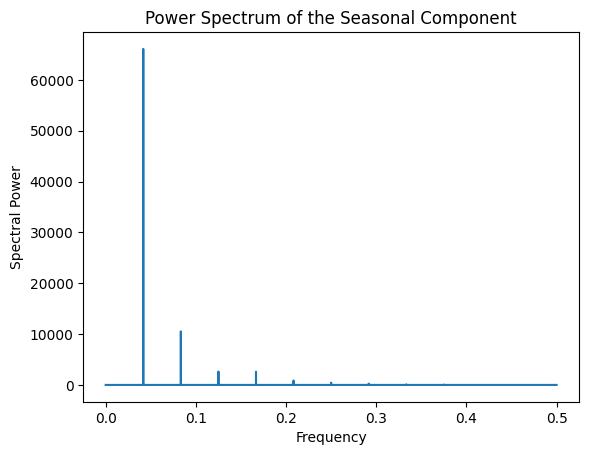

In [56]:
frequencies_magna, spectrum_magna = periodogram(seasonal_magna.dropna(), scaling = 'spectrum')
plt.figure()
plt.plot(frequencies_magna, spectrum_magna)
plt.title('Power Spectrum of the Seasonal Component')
plt.xlabel('Frequency')
plt.ylabel('Spectral Power')
plt.show()

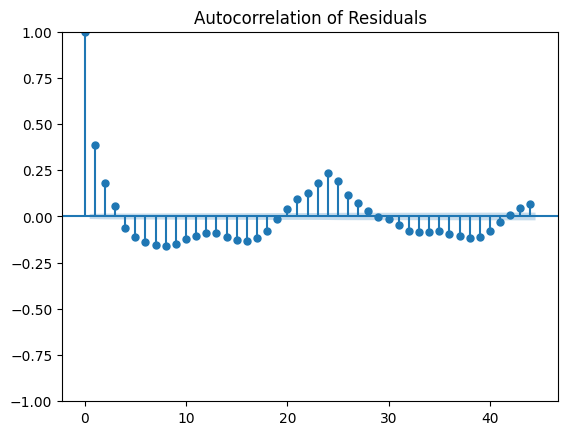

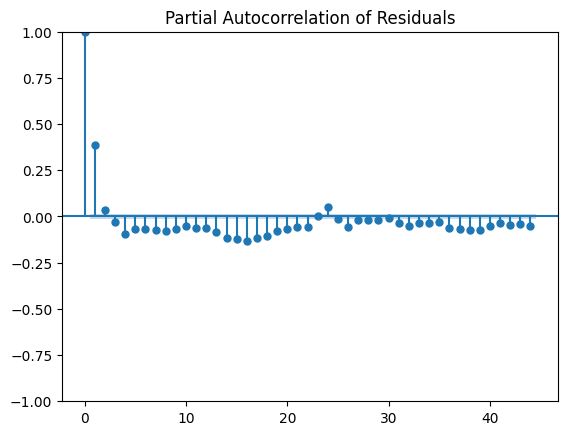

In [57]:
plot_acf(residual_magna.dropna())
plt.title('Autocorrelation of Residuals')
plt.show()

plot_pacf(residual_magna.dropna())
plt.title('Partial Autocorrelation of Residuals')
plt.show()

***Análisis de Demanda Premium***

In [58]:
if not isinstance(df_premium.index, pd.DatetimeIndex):
    df_premium.index = pd.to_datetime(df_premium.index)

print("Start date:", df_premium.index[0])
print("End date:", df_premium.index[-1])
print("Number of data points:", len(df_premium))

if df_premium.index[0] <= pd.Timestamp.max - pd.DateOffset(days = len(df_premium)):
    if not df_premium.index.freq:
        df_premium.index.freq = 'h'

Start date: 2022-01-03 00:00:00
End date: 2024-04-30 23:00:00
Number of data points: 20376


/var/folders/hz/rf4k4thx75ng3j5rtm1h4wg80000gn/T/ipykernel_1056/1102146886.py:8: UserWarning:

Discarding nonzero nanoseconds in conversion.



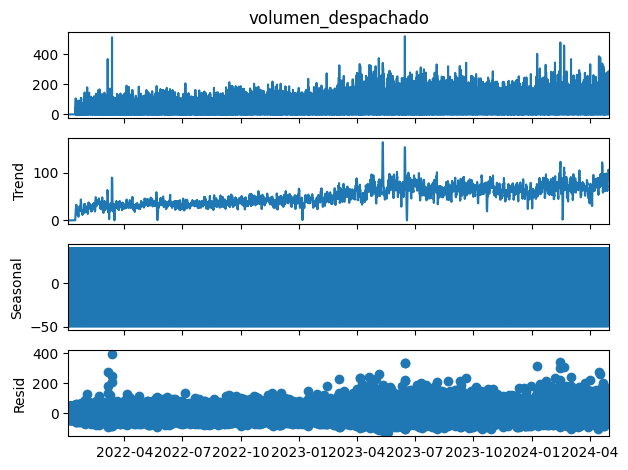

In [59]:
decomposition_premium = sm.tsa.seasonal_decompose(df_premium['volumen_despachado'], model = 'additive')

trend_premium = decomposition_premium.trend
seasonal_premium = decomposition_premium.seasonal
residual_premium = decomposition_premium.resid

fig = decomposition_premium.plot()
plt.show()

In [60]:
fig = px.line(x = df_premium['volumen_despachado'].index, y = seasonal_premium, labels={'y': 'Seasonality', 'x': 'Date'}, title = 'Seasonality Component')
fig.show()

In [61]:
print("Statistical Summary of Trend Component:")
print(trend_premium.describe())

print("\nStatistical Summary of Seasonal Component:")
print(seasonal_premium.describe())

print("\nStatistical Summary of Residual Component:")
print(residual_premium.describe())

Statistical Summary of Trend Component:
count    20352.000000
mean        51.051016
std         20.403300
min          0.000000
25%         35.702766
50%         48.564573
75%         66.234286
max        164.223083
Name: trend, dtype: float64

Statistical Summary of Seasonal Component:
count    2.037600e+04
mean    -8.676042e-16
std      3.351327e+01
min     -4.974718e+01
25%     -3.666439e+01
50%      1.564700e+01
75%      2.988250e+01
max      4.020807e+01
Name: seasonal, dtype: float64

Statistical Summary of Residual Component:
count    20352.000000
mean        -0.005143
std         37.878559
min       -124.950989
25%        -24.516610
50%         -2.744473
75%         17.821488
max        392.213510
Name: resid, dtype: float64


In [62]:
original = df_premium['volumen_despachado']
print("Correlation with Original Series:")
print("Trend Correlation:", original.corr(trend_premium))
print("Seasonal Correlation:", original.corr(seasonal_premium))
print("Residual Correlation:", original.corr(residual_premium))

Correlation with Original Series:
Trend Correlation: 0.38349471614289876
Seasonal Correlation: 0.6117207727260316
Residual Correlation: 0.697841350701923


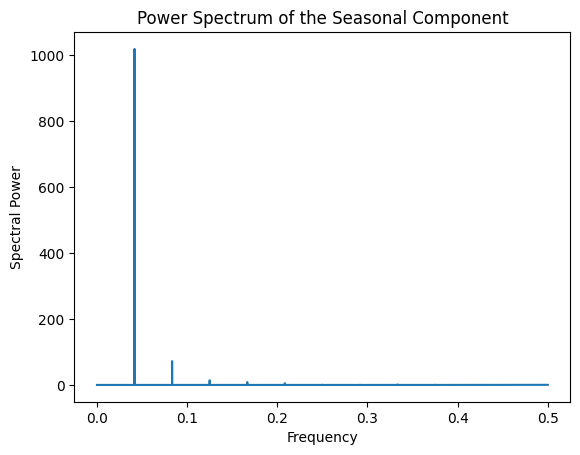

In [63]:
frequencies_premium, spectrum_premium = periodogram(seasonal_premium.dropna(), scaling = 'spectrum')
plt.figure()
plt.plot(frequencies_premium, spectrum_premium)
plt.title('Power Spectrum of the Seasonal Component')
plt.xlabel('Frequency')
plt.ylabel('Spectral Power')
plt.show()

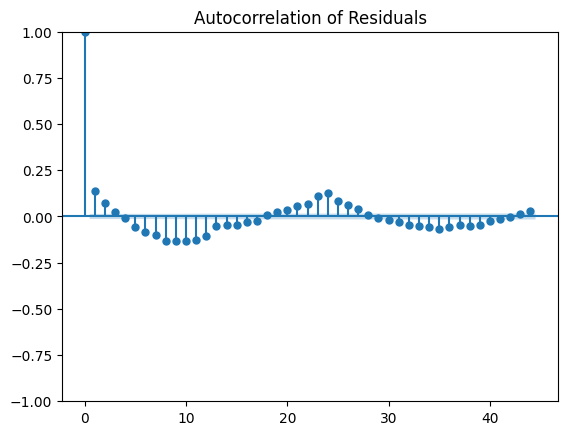

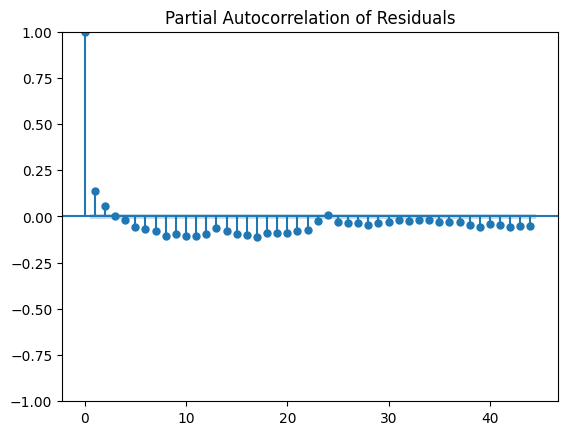

In [64]:
plot_acf(residual_premium.dropna())
plt.title('Autocorrelation of Residuals')
plt.show()

plot_pacf(residual_premium.dropna())
plt.title('Partial Autocorrelation of Residuals')
plt.show()

***Análisis de Demanda Diesel***

In [65]:
if not isinstance(df_diesel.index, pd.DatetimeIndex):
    df_diesel.index = pd.to_datetime(df_diesel.index)

print("Start date:", df_diesel.index[0])
print("End date:", df_diesel.index[-1])
print("Number of data points:", len(df_diesel))

if df_diesel.index[0] <= pd.Timestamp.max - pd.DateOffset(days = len(df_diesel)):
    if not df_diesel.index.freq:
        df_diesel.index.freq = 'h'

Start date: 2022-01-03 00:00:00
End date: 2024-04-30 23:00:00
Number of data points: 20376


/var/folders/hz/rf4k4thx75ng3j5rtm1h4wg80000gn/T/ipykernel_1056/3856004539.py:8: UserWarning:

Discarding nonzero nanoseconds in conversion.



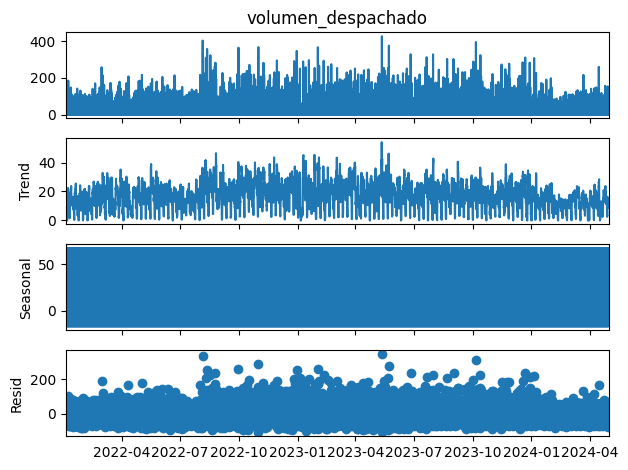

In [66]:
decomposition_diesel = sm.tsa.seasonal_decompose(df_diesel['volumen_despachado'], model = 'additive')

trend_diesel = decomposition_diesel.trend
seasonal_diesel = decomposition_diesel.seasonal
residual_diesel = decomposition_diesel.resid

fig = decomposition_diesel.plot()
plt.show()

In [67]:
fig = px.line(x = df_diesel['volumen_despachado'].index, y = seasonal_diesel, labels={'y': 'Seasonality', 'x': 'Date'}, title = 'Seasonality Component')
fig.show()

**Conclusiones Avance 1**

Para este análisis de la base de datos de nuestro Proyecto de Modelo para Optimización de Precios en Estaciones de Autoservicio tomamos como referencia la base diaria de ventas para el periodo 2022-2024 (abril). En primer lugar, consolidamos las bases de datos asegurándonos que cumplan con el tipo de dato correspondiente a la naturaleza de cada variable para poder analizar el contenido de la base de datos. Encontramos una gran cantidad de datos faltantes en variables relacionadas a información de los clientes de las gasolineras, como placa o tipo de vehículo, por lo cual no se podría realizar una segmentación de clientes de manera óptima, debido a que en algunos casos la data faltante representa alrededor del 70% de la base total.

Las variables completas hacen referencia a información de la transacción de Ventas de 1 gasolinera, en la cual encontramos 3 variables numéricas, 2 variables categóricas, 2 variables que hacen referencia a la fecha de la transacción y 1 variable de identificación de la transacción. Encontramos valores atípicos que pueden deberse a una incorrecta digitación de la información (por ejemplo, una venta fue de 6 millones de galones) por lo cual decidimos filtrar el 10% de los valores más altos de la variable Cantidad para poder realizar el análisis exploratorio. En cuanto a información temporal, realizamos varios análisis gráficos de las series de tiempo y el principal hallazgo fue que la cantidad de combustible MAGNA (categoría de producto más vendido por la gasolinera) presenta una tendencia decreciente en el periodo analizado, mientras que la venta del combustible PREMIUM muestra una ligera tendencia creciente en el mismo periodo.

------------------

**Avance 2. Ingeniería de características**

Mayo 2024

**Objetivos**

2.3 Crear nuevas características para mejorar el rendimiento de los modelos.

2.4 Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.

**Instrucciones**

En esta fase, conocida como ingeniería de características (FE - Feature Engineering):

Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático. El procesamiento puede incluir:
Generación de nuevas características
Discretización o binning
Codificación (ordinal, one hot,…)
Escalamiento (normalización, estandarización, min – max,…)
Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)
* Todas las decisiones y técnicas empleadas deben ser justificadas.

 

Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. Los ejemplos siguientes son ilustrativos, pero no exhaustivos, de lo que se podría aplicar:
Umbral de varianza
Correlación
Chi-cuadrado
ANOVA
Análisis de componentes principales (PCA)
Análisis factorial (FA)
* Es necesario fundamentar los métodos ejecutados.

 

Incluir conclusiones de la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML.

In [68]:
print("Statistical Summary of Trend Component:")
print(trend_diesel.describe())

print("\nStatistical Summary of Seasonal Component:")
print(seasonal_diesel.describe())

print("\nStatistical Summary of Residual Component:")
print(residual_diesel.describe())

Statistical Summary of Trend Component:
count    20352.000000
mean        17.102592
std          8.684034
min          0.000000
25%         11.419583
50%         17.397510
75%         22.887021
max         54.031208
Name: trend, dtype: float64

Statistical Summary of Seasonal Component:
count    2.037600e+04
mean     3.835871e-16
std      2.010416e+01
min     -1.695829e+01
25%     -1.633007e+01
50%     -4.519686e+00
75%      7.162788e+00
max      6.753095e+01
Name: seasonal, dtype: float64

Statistical Summary of Residual Component:
count    20352.000000
mean         0.001429
std         28.581841
min       -107.439867
25%        -13.315737
50%         -2.487500
75%          7.489637
max        345.989084
Name: resid, dtype: float64


In [69]:
original = df_diesel['volumen_despachado']
print("Correlation with Original Series:")
print("Trend Correlation:", original.corr(trend_diesel))
print("Seasonal Correlation:", original.corr(seasonal_diesel))
print("Residual Correlation:", original.corr(residual_diesel))

Correlation with Original Series:
Trend Correlation: 0.2605240161444729
Seasonal Correlation: 0.5552005514722127
Residual Correlation: 0.7960786058644154


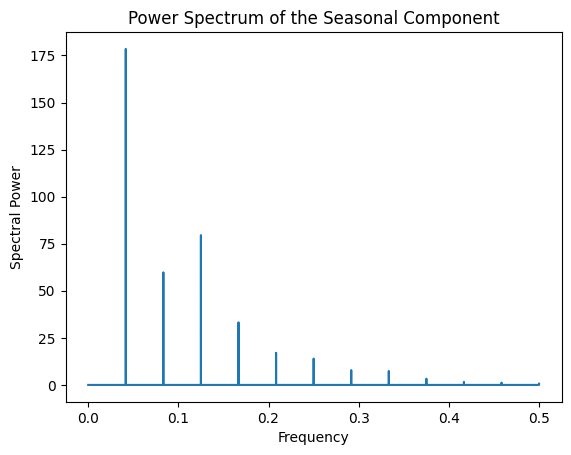

In [70]:
frequencies_diesel, spectrum_diesel = periodogram(seasonal_diesel.dropna(), scaling = 'spectrum')
plt.figure()
plt.plot(frequencies_diesel, spectrum_diesel)
plt.title('Power Spectrum of the Seasonal Component')
plt.xlabel('Frequency')
plt.ylabel('Spectral Power')
plt.show()

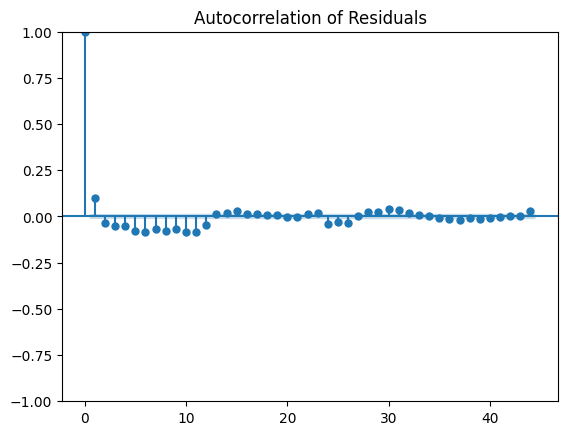

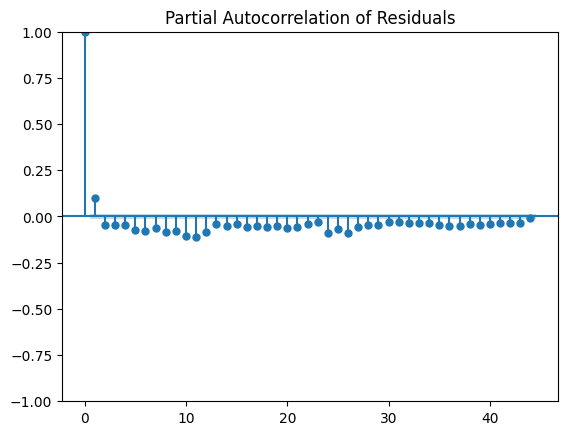

In [71]:
plot_acf(residual_diesel.dropna())
plt.title('Autocorrelation of Residuals')
plt.show()

plot_pacf(residual_diesel.dropna())
plt.title('Partial Autocorrelation of Residuals')
plt.show()

In [72]:
df_magna.to_pickle(f'{path}base_magna.pkl')
df_premium.to_pickle(f'{path}base_premium.pkl')
df_diesel.to_pickle(f'{path}base_diesel.pkl')

**Identificación de Factores Exógenos**

Un factor importante para determinar el precio de venta de gasolina es el precio del petróleo del cual se derivó la gasolina que se venderá. Para esto tomamos la base del EIA (US Energy Information Administration) del precio de petróleo BRENT (referencia para México). En esta sección analizaremos la relación del precio del petróleo con los precios de compra (es decir los precios a los cuales las gasolineras adquirieron el producto). Debido a que el precio internacional del petróleo no tiene un efecto inmediato sobre el precio de los proveedores, se debe realizar un análisis de correlación con rezago, para poder determinar el impacto del precio del petróleo en los precios de distribución.

In [73]:
base_master = pd.read_pickle(f'{path}base_master.pkl')

In [74]:
db_petroleo = pd.read_csv(f'{path}Europe_Brent_Spot_Price_FOB.csv', header = None)
db_petroleo.columns = ['fecha', 'precio_brent']
db_petroleo['market_date'] = pd.to_datetime(db_petroleo['fecha'])

In [75]:
all_days = pd.date_range(start = db_petroleo['market_date'].min(), end = db_petroleo['market_date'].max(), freq = 'D')

In [76]:
db_petroleo = db_petroleo.set_index('market_date').reindex(all_days).ffill()
db_petroleo = db_petroleo.reset_index()
db_petroleo = db_petroleo.drop(index = 0).reset_index(drop = True)
db_petroleo = db_petroleo.rename(columns = {'index': 'market_date'})
ppetroleo = db_petroleo[db_petroleo['market_date'] > '2021-12-30']

Básicamente podemos observar que existe una correlación visual entre el precio del petróleo Brent y el precio neto de compra al cual la gasolinera adquiere los derivados de petróleo. Con esta información visual, haremos un análisis de correlación con rezago para determinar el rezago óptimo del precio del petróleo con el costo de adquisición por tipo de combustible.

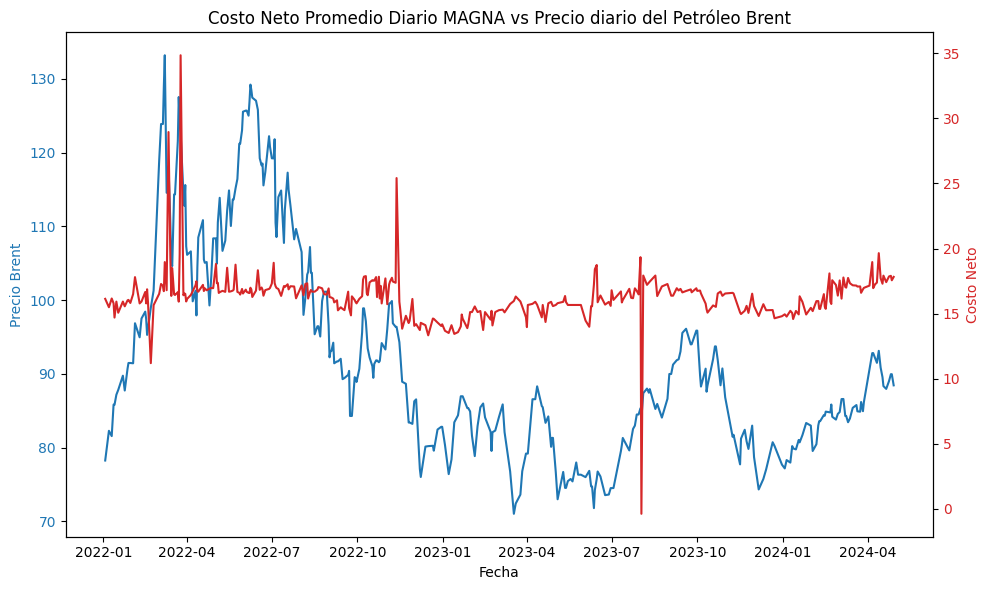

In [77]:
base_combustible = base_master.loc[base_master['producto'] == 'magna']

precio_promedio_diario = base_combustible.groupby('purchase_date')['costo_neto'].mean().reset_index()

precio_promedio_diario.columns = ['purchase_date', 'costo_neto']

merged_db_price_cost = pd.merge(precio_promedio_diario, ppetroleo, left_on = 'purchase_date', right_on = 'market_date', how = 'inner')

data_p_c = merged_db_price_cost[['purchase_date', 'costo_neto', 'market_date', 'precio_brent']]

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio Brent', color = color)
ax1.plot(data_p_c['market_date'], data_p_c['precio_brent'], color = color, label = 'Precio Brent')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Costo Neto', color = color)
ax2.plot(data_p_c['market_date'], data_p_c['costo_neto'], color=color, label='Costo Neto')
ax2.tick_params(axis='y', labelcolor=color)

# Título y leyenda
plt.title('Costo Neto Promedio Diario MAGNA vs Precio diario del Petróleo Brent')
fig.tight_layout()
plt.show()

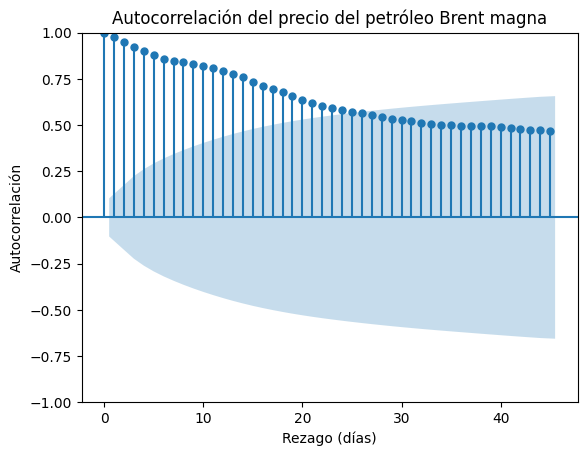

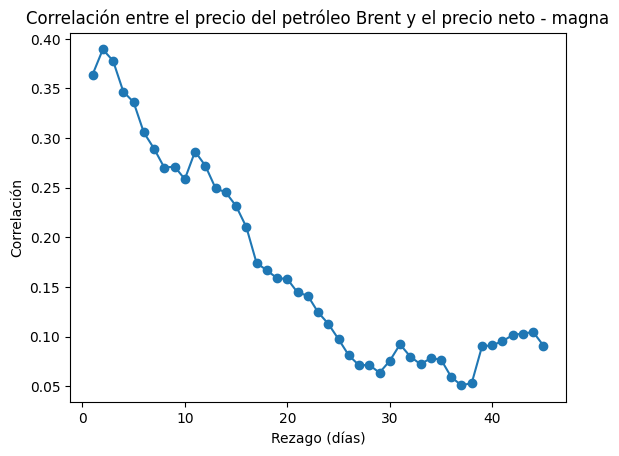

Rezago óptimo: 2


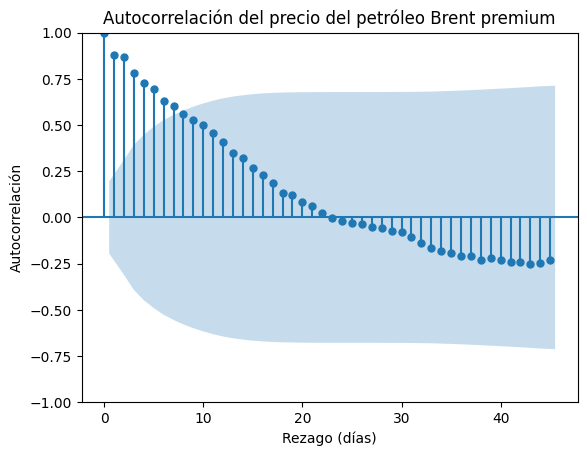

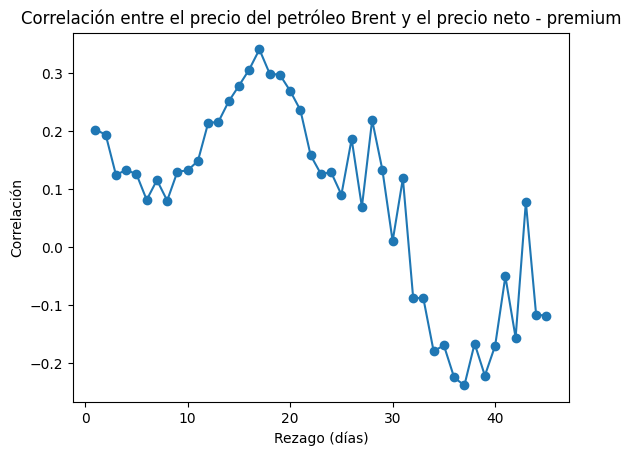

Rezago óptimo: 17


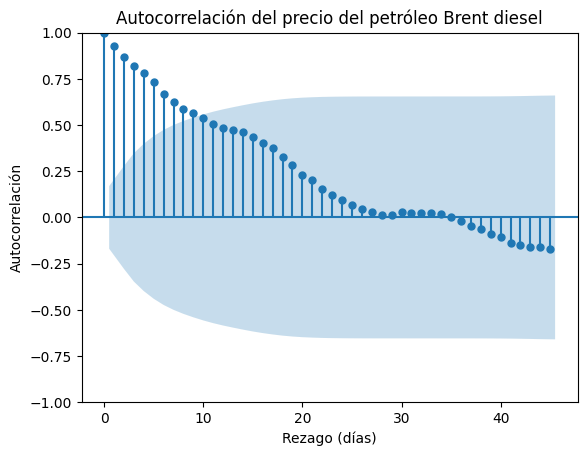

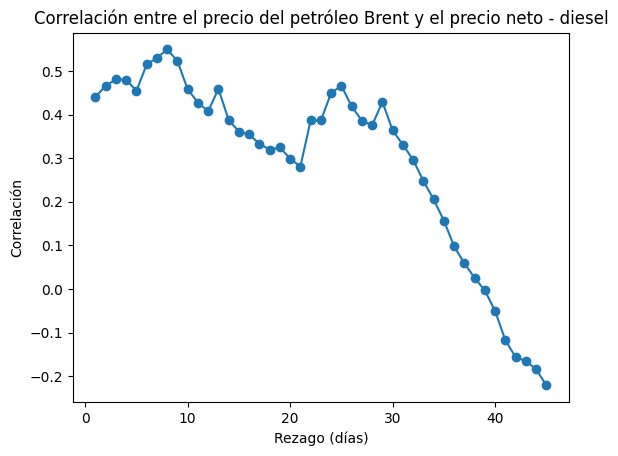

Rezago óptimo: 8


In [78]:
combustibles = ['magna', 'premium', 'diesel']

for combustible in combustibles:
    base_combustible = base_master.loc[base_master['producto'] == combustible]

    precio_promedio_diario = base_combustible.groupby('purchase_date')['costo_neto'].mean().reset_index()
    precio_promedio_diario.columns = ['purchase_date', 'costo_neto']
    merged_data = pd.merge(precio_promedio_diario, ppetroleo, left_on = 'purchase_date', right_on = 'market_date', how = 'inner')
    
    data = merged_data[['purchase_date', 'costo_neto', 'market_date', 'precio_brent']]

    lag_acf = plot_acf(data['precio_brent'], lags = 45)
  
    plt.xlabel('Rezago (días)')
    plt.ylabel('Autocorrelación')
    plt.title(f'Autocorrelación del precio del petróleo Brent {combustible}')
    plt.show()

  # Calcular la correlación entre el precio del petróleo Brent y el costo neto con diferentes rezagos
    correlation_results = {}
    for lag in range(1, 46):
        data['precio_brent_lagged'] = data['precio_brent'].shift(lag)
        correlation = data[['precio_brent_lagged', 'costo_neto']].corr().iloc[0, 1]
        correlation_results[lag] = correlation


    plt.plot(list(correlation_results.keys()), list(correlation_results.values()), marker = 'o')
    plt.xlabel('Rezago (días)')
    plt.ylabel('Correlación')
    plt.title(f'Correlación entre el precio del petróleo Brent y el precio neto - {combustible}')
    plt.show()

    optimal_lag = max(correlation_results, key = lambda key: abs(correlation_results[key]))

    print("Rezago óptimo:", optimal_lag)

Tras el análisis de correlación con rezago pudimos determinar que existen diferentes rezagos óptimos para cada tipo de combustible. Para MAGNA, el rezago óptimo es de 2 días, es decir, el precio del petróleo con un rezago de 2 días tiene mayor correlación con el costo de adquisición. Para PREMIUM, el rezago óptimo es de 17 días y para DIESEL, el rezago óptimo es de 8 días. Esta diferencia en rezagos puede deberse a la naturaleza del tipo de combustible.  Debido a que encontramos esta correlación, debemos agregar la variable del precio del petróleo a nuestra base de datos. Para esto agregaremos el precio del petróleo con su rezago óptimo por cada tipo de combustible para cada data frame de combustible.

In [79]:
df_magna = pd.read_pickle(f'{path}base_magna.pkl')
df_premium = pd.read_pickle(f'{path}base_premium.pkl')
df_diesel = pd.read_pickle(f'{path}base_diesel.pkl')

In [80]:
df_magna['purchase_timeStamp'] = df_magna['purchase_timeStamp'].dt.floor('D')
df_premium['purchase_timeStamp'] = df_premium['purchase_timeStamp'].dt.floor('D')
df_diesel['purchase_timeStamp'] = df_diesel['purchase_timeStamp'].dt.floor('D')

In [81]:
rezago_magna = 2
rezago_premium = 17
rezago_diesel = 8

ppetroleo_magna = db_petroleo.copy()
ppetroleo_magna['market_date'] = ppetroleo_magna['market_date'] + pd.DateOffset(days = rezago_magna)
df_magna = pd.merge(df_magna.reset_index(), ppetroleo_magna.drop(['fecha'], axis = 1), left_on = 'purchase_timeStamp', right_on = 'market_date', how = 'inner')
df_magna.drop('market_date', axis = 1, inplace = True)
df_magna = date_info(df_magna,'sale_timeStamp')

ppetroleo_premium = db_petroleo.copy()
ppetroleo_premium['market_date'] = ppetroleo_premium['market_date'] + pd.DateOffset(days = rezago_premium)
df_premium = pd.merge(df_premium.reset_index(), ppetroleo_premium.drop(['fecha'], axis = 1), left_on = 'purchase_timeStamp', right_on = 'market_date', how = 'inner')
df_premium.drop('market_date', axis = 1, inplace = True)
df_premium = date_info(df_premium,'sale_timeStamp')

ppetroleo_diesel = db_petroleo.copy()
ppetroleo_diesel['market_date'] = ppetroleo_diesel['market_date'] + pd.DateOffset(days = rezago_diesel)
df_diesel = pd.merge(df_diesel.reset_index(), ppetroleo_diesel.drop(['fecha'], axis = 1), left_on = 'purchase_timeStamp', right_on = 'market_date', how = 'inner')
df_diesel.drop('market_date', axis = 1, inplace = True)
df_diesel = date_info(df_diesel,'sale_timeStamp')


In [82]:
df_magna.to_pickle(f'{path}base_magna_final.pkl')
df_premium.to_pickle(f'{path}base_premium_final.pkl')
df_diesel.to_pickle(f'{path}base_diesel_final.pkl')

**Conclusiones Avance 2**

Para nuestro modelo de optimización de precios la preparación de datos es el paso más importante previo al modelamiento debido a que logramos comprender la base de datos disponible por parte de las gasolineras, al igual que el contexto económico del negocio y las variables que afectan las ventas de combustible. 

En la comprensión de la base de datos, identificamos variables de oferta y demanda de las gasolineras al igual que obtuvimos nuestra variable dependiente para nuestro modelo que es el Margen de Ganancias. De igual manera, obtuvimos información sobre el comportamiento temporal de nuestras variables para extraer insights sobre el funcionamiento del negocio y su estado actual (como mencionamos anteriormente, encontramos una reducción en el volumen de combustible vendido a lo largo del periodo 2022- 2024). También ligamos el comportamiento de los costos de combustibles al precio internacional del petróleo, de tal manera que obtuvimos una variable externa que nos otorga bastante información que puede ser útil en el modelamiento de optimización de precios.

También comprendimos que es necesaria la división de nuestra base de datos en tipo de Combustible ofertado. Esto debido a que la estacionalidad y tendencia de ventas varía de acuerdo con el tipo de combustible, al igual que el precio del petróleo influye de diferente manera a cada tipo de combustible. Por lo cual, en lugar de crear variables dummies para cada tipo de combustible, vamos a crear un modelo especifico para cada tipo de combustible disponible en nuestra base de datos.

-----------------------------

**Avance 3.Ingeniería de características**
    
Mayo 2024

**Objetivos**
    
3.1 Establecer las medidas de calidad del modelo de aprendizaje automático.

3.2 Proporcionar un marco de referencia para evaluar y mejorar modelos más avanzado
.

**Instruccion***

Este avance consiste en construir un modelo de referencia que permita evaluar la viabilidad del problema. Si el baseline tiene un rendimiento similar al azar, podría indicar que el problema es intrínsecamente difícil o que los datos no contienen suficiente información para predecir el objetivo. De lo contrario, el baseline podría como una solución mínima aceptable cuando se trabaja en escenarios donde incluso un modelo simple puede proporcionar valor.

Un baseline facilita también la gestión de expectativas, tanto dentro del equipo como con los stakeholders, pues proporciona una comprensión inicial de lo que se puede lograr con métodos simples antes de invertir tiempo y recursos en enfoques más complejos.

Las siguientes son algunas de las preguntas que deberán abordar durante esta fase:

¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo? 
¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.
¿El modelo está sub/sobreajustando los datos de entrenamiento?
¿Cuál es la métrica adecuada para este problema de negocio? 
¿Cuál debería ser el desempeño mínimo obtener?
 o real, en un conjunto de variables útiles para el aprendizaje automático. El procesamiento puede incluir:
Generación de nuevas características
Discretización o binning
Codificación (ordinal, one hot,…)
Escalamiento (normalización, estandarización, min – max,…)
Transformación (logarítmica, exponencial, raíz cuadrada, Box – Cox, Yeo – Johnson,…)
* Todas las decisiones y técnicas empleadas deben ser justificadas.


Además, se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento. Los ejemplos siguientes son ilustrativos, pero no exhaustivos, de lo que se podría aplicar:
Umbral de varianza
Correlación
Chi-cuadrado
ANOVA
Análisis de componentes principales (PCA)
Análisis factorial (FA)
* Es necesario fundamentar los métodos ejecutados.

Incluir conclusiones de la fase de "Preparación de los datos" en el contexto de la metodología CRISP-ML.

Para nuestro modelo baseline vamos a elegir un modelo de Random Forest para la demanda (volumen_despachado) y un modelo genético para la determinación del precio. Elegimos este tipo de algortimo porque nos facilita capturar las relaciones de mayor complejidad entre variable dependiente y variables independientes. De igual manera, el Random Forest ayuda a la reducción de *overfitting*. También porque nos permite identificar las variables importantes en nuestra predicción, de tal manera que podamos  eliminar aquellas que no afectan significativamente a la variable objetivo y puedan causar ruido en la predicción si son incluidas. De igual manera, utilizamos un modelo genético debido a su capacidad de capturar relaciones complejas entre las variables, la capacidad de incorporar restricciones a las diferentes variables del negocio, la penalización a la variable objetivo, que en este caso evita que el precio óptimo se encuentre en un rango fuera de lo normal (es decir, evita que el precio óptimo sea absurdamente alto porque a mayor precio mayor rentabilidad, y lo ubica dentro de un rango razonable dentro de las datos observados). 

In [83]:
df_magna = pd.read_pickle(f'{path}base_magna_final.pkl')
df_premium = pd.read_pickle(f'{path}base_premium_final.pkl')
df_diesel = pd.read_pickle(f'{path}base_diesel_final.pkl')

Antes de desarrollar el modelo realizamos una codificación de las variables temporales para capturar el ciclo temporal en los datos. Esto se realiza con el seno y coseno de las variables temporales de hora, día y mes. 

In [84]:
def feature_engineering(df_interest):
    df_interest['hour_sin'] = np.sin(2 * np.pi * df_interest['hour']/23.0)
    df_interest['hour_cos'] = np.cos(2 * np.pi * df_interest['hour']/23.0)
    df_interest['day_sin'] = np.sin(2 * np.pi * df_interest['dow_n']/6.0)
    df_interest['day_cos'] = np.cos(2 * np.pi * df_interest['dow_n']/6.0)
    df_interest['month_sin'] = np.sin(2 * np.pi * df_interest['month']/11.0)
    df_interest['month_cos'] = np.cos(2 * np.pi * df_interest['month']/11.0)
    df_interest.drop(['hour', 'dow_n', 'month'], axis = 1, inplace = True)
    return df_interest

Para nuestro modelo de optimización de precios de gasolina, reiteramos que vamos a trabajar sobre 3 tipos de combustible por separado (MAGNA, PREMIUM, DIESEL), de tal manera que obtendremos 3 modelos diferentes de optimización de precios. 

In [85]:
def setup_models(df_interest, features, target):
    features = feature_engineering(df_interest[features].copy())
    target = df_interest[target].squeeze()

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size = 0.2, random_state = 42)
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print('Demand Prediction Model MSE:', mse)
    
    return model, X_train, scaler, df_interest['precio_neto'].mean(), features

Otra variable que estamos agregando para el modelo genético es la elasticidad de la demanda. Esta variable también es relevante porque nos ayudará a determinar como cambia la demanda cuando el precio se modifica. La elasticidad es importante porque nos da información sobre el producto, por ejemplo, si una pequeña variación del precio genera un cambio significativo en la demanda entonces el producto se considera elástico); o pese a un cambio importante en el precio, la cantidad demandada se mantiene igual, el producto se considera inelástico. Para obtener la elasticidad de la demanda estamos realizando una regresión linear con los logaritmos de nuestros datos de precio_neto y volumen_despachado. 

In [86]:
pe_features = ['volumen_despachado', 'precio_neto']

In [87]:
def pricing_elasticity_prep(df_interest,features):
    new_df = df_interest[features].copy()
    type_dict = {}
    
    for i, feature in enumerate(features):
        type_dict[i] = df_interest[feature].dtype
    
    new_df.replace(0, pd.NA, inplace = True)
    new_df.dropna(inplace = True)

    for i, feature in enumerate(features):
        new_df[feature] = new_df[feature].astype(type_dict[i])

    new_df['log_price'] = np.log(new_df['precio_neto'])
    new_df['log_demand'] = np.log(new_df['volumen_despachado'])
    
    return new_df

In [88]:
df_magna_alt = pricing_elasticity_prep(df_magna, pe_features)
df_premium_alt = pricing_elasticity_prep(df_premium, pe_features)
df_diesel_alt = pricing_elasticity_prep(df_diesel, pe_features)

In [89]:
model_lr_elasticity_magna = LinearRegression()
model_lr_elasticity_magna.fit(df_magna_alt[['log_price']], df_magna_alt[['log_demand']])
price_elasticity_magna = model_lr_elasticity_magna.coef_[0]

model_lr_elasticity_premium = LinearRegression()
model_lr_elasticity_premium.fit(df_premium_alt[['log_price']], df_premium_alt[['log_demand']])
price_elasticity_premium = model_lr_elasticity_premium.coef_[0]

model_lr_elasticity_diesel = LinearRegression()
model_lr_elasticity_diesel.fit(df_diesel_alt[['log_price']], df_diesel_alt[['log_demand']])
price_elasticity_diesel = model_lr_elasticity_diesel.coef_[0]

In [90]:
print(f'Elasticidad Magna: {price_elasticity_magna[0]:.2f}')
print(f'Elasticidad Premium: {price_elasticity_premium[0]:.2f}')
print(f'Elasticidad Diesel: {price_elasticity_diesel[0]:.2f}')

Elasticidad Magna: -0.45
Elasticidad Premium: 2.15
Elasticidad Diesel: 0.10


**Optmización de Modelo: Modelo Genético**

Una vez que obtenemos el RandomForest del volumen despachado, procedemos a realizar un algoritmo genético para la optimización de precio. Dentro del modelo genético estamos generando individuos, población, cruce, mutación y selección. Una vez que definimos estos parametros procedemos a calcular el margun bruto utilizando nuestra base de datos de entrenamiento, nuestro modelo RandomForest, la elasticidad del precio (que calculamos con regresión lineal) y el precio actual. Por último, se incluye una penalización calculada en función a la diferencia del precio_pred con el precio actual. 

In [91]:
def init_toolbox(model, train_data, scaler, current_price, lower_bound_ratio, upper_bound_ratio, elasticity, feature_names):
    
    creator.create('FitnessMax', base.Fitness, weights = (1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    lower_bound = current_price * lower_bound_ratio
    upper_bound = current_price * upper_bound_ratio
    
    toolbox = base.Toolbox()
    toolbox.register('attr_float', random.uniform, lower_bound, upper_bound)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    toolbox.register('evaluate', eval_gross_margin, train_data = train_data, model = model, 
                     scaler = scaler, current_price = current_price, elasticity = elasticity, feature_names = feature_names)
    toolbox.register('mate', tools.cxBlend, alpha = 0.5)
    toolbox.register('mutate', tools.mutGaussian, mu = 0, sigma = 1, indpb = 0.2)
    toolbox.register('select', tools.selTournament, tournsize = 3)
    
    return toolbox

In [92]:
def eval_gross_margin(individual, train_data, model, scaler, current_price, elasticity, feature_names):
    try:
        price = individual[0]
        # Create a dataframe to simulate the scenario with the evaluated price
        mean_values = np.mean(train_data[:, 1:], axis=0) 
        data_with_price = np.insert(mean_values, 0, price)
        temp_features = pd.DataFrame([data_with_price], columns = feature_names)
        
        # Calculate the scaled features for the model
        scaled_features = scaler.transform(temp_features)
        predicted_demand = model.predict(scaled_features)[0]
        
        # Extract cost of goods sold from the temporary features, ensuring it corresponds to the simulated scenario
        cost_of_goods_sold = temp_features['costo_neto'].iloc[0]
        
        gross_margin = (price - cost_of_goods_sold) * predicted_demand
        penalty_factor = 100
        penalty = penalty_factor * (abs(price - current_price) / current_price) ** (-elasticity)
        gross_margin -= penalty
        return (gross_margin,)
    except Exception as e:
        print("Error in evalGrossMargin:", e)
        return (0,)  # Return a default or zero fitness in case of error

In [93]:
def optimize_price(df, features, target, elasticity, lower_bound_ratio, upper_bound_ratio):
    model, X_train, scaler, current_price, features_refined = setup_models(df, features, target)
    elasticity = -0.5 
    
    lower_bound = current_price * lower_bound_ratio
    upper_bound = current_price * upper_bound_ratio
    
    toolbox = init_toolbox(model, X_train, scaler, current_price, lower_bound_ratio, upper_bound_ratio, elasticity, features_refined.columns)

    population = toolbox.population(n = 50)
    NGEN, CXPB, MUTPB = 40, 0.5, 0.2

    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb = CXPB, mutpb = MUTPB)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = toolbox.select(offspring, len(population))
        fits = [ind.fitness.values[0] for ind in population]
        print(f"Generation {gen}: Max Fit {max(fits)}, Avg Fit {np.mean(fits)}")

    top_individual = tools.selBest(population, k = 1)[0]
    optimal_price = top_individual[0]
    max_gross_margin = top_individual.fitness.values[0]

    print(f'Optimal price: ${optimal_price:.2f}')
    print(f'Maximum Gross Margin: ${max_gross_margin:.2f}')

    creator.__delattr__('FitnessMax')
    creator.__delattr__('Individual')
    
    return optimal_price, max_gross_margin

Para los features de nuestro modelo estamos incluyendo precio_neto, costo_neto, precio_brent (rezagado), y variables temporales de hora, día y mes. Nuestra variable objetivo es el volumen despachado o como lo definimos la demanda de la gasolinera. 

In [94]:
model_features = ['precio_neto', 'costo_neto', 'precio_brent', 'hour', 'month', 'dow_n']
model_target = ['volumen_despachado']

In [95]:
magna_price, magna_gross_margin = optimize_price(df_magna, model_features, model_target, price_elasticity_magna, 0.7, 1.3)

Demand Prediction Model MSE: 24260.906214291863
Generation 0: Max Fit 12163.997008429169, Avg Fit 9649.506718220004
Generation 1: Max Fit 12280.29700729585, Avg Fit 10263.876515923534
Generation 2: Max Fit 12280.29700729585, Avg Fit 10620.921869395817
Generation 3: Max Fit 12306.978895650855, Avg Fit 11231.193843997891
Generation 4: Max Fit 12306.978895650855, Avg Fit 11900.82931598197
Generation 5: Max Fit 12306.978895650855, Avg Fit 12103.988224627607
Generation 6: Max Fit 12306.978895650855, Avg Fit 12247.938854791872
Generation 7: Max Fit 12306.978895650855, Avg Fit 12300.66049242804
Generation 8: Max Fit 12307.549933085485, Avg Fit 12304.588185377293
Generation 9: Max Fit 12307.549933085485, Avg Fit 12306.797391699063
Generation 10: Max Fit 12307.595638425044, Avg Fit 12307.242413232741
Generation 11: Max Fit 12307.549933085485, Avg Fit 12307.432518536989
Generation 12: Max Fit 12307.597524842127, Avg Fit 12307.511625736879
Generation 13: Max Fit 12307.628440557837, Avg Fit 12307.

In [96]:
premium_price, premium_gross_margin = optimize_price(df_premium, model_features, model_target, price_elasticity_premium, 0.7, 1.3)

Demand Prediction Model MSE: 1659.8372604914277
Generation 0: Max Fit 1137.7284080158336, Avg Fit 696.1954420717005
Generation 1: Max Fit 1152.562849596964, Avg Fit 1012.2362710361466
Generation 2: Max Fit 1152.562849596964, Avg Fit 1079.438595630484
Generation 3: Max Fit 1153.4618181542614, Avg Fit 1113.117650506139
Generation 4: Max Fit 1186.579906813815, Avg Fit 1143.1121787175425
Generation 5: Max Fit 1207.7943240068766, Avg Fit 1167.9025518359394
Generation 6: Max Fit 1228.0458203638195, Avg Fit 1189.192409798333
Generation 7: Max Fit 1228.0458203638195, Avg Fit 1203.5759021987394
Generation 8: Max Fit 1236.892965686683, Avg Fit 1213.226609844868
Generation 9: Max Fit 1241.1321478148432, Avg Fit 1223.2597927269137
Generation 10: Max Fit 1290.9622186831389, Avg Fit 1240.0525593798304
Generation 11: Max Fit 1341.5660199817657, Avg Fit 1255.5138356049824
Generation 12: Max Fit 1341.5660199817657, Avg Fit 1285.764812020251
Generation 13: Max Fit 1338.4423140161007, Avg Fit 1309.917142

In [97]:
diesel_price, diesel_gross_margin = optimize_price(df_diesel, model_features, model_target, price_elasticity_diesel, 0.7, 1.3)

Demand Prediction Model MSE: 1059.0441196169459
Generation 0: Max Fit 800.9318633956192, Avg Fit 668.1335473721281
Generation 1: Max Fit 892.2403760324911, Avg Fit 770.8559212395257
Generation 2: Max Fit 892.2403760324911, Avg Fit 815.4127069162137
Generation 3: Max Fit 935.3603124029764, Avg Fit 849.8725068569904
Generation 4: Max Fit 945.8461877743877, Avg Fit 900.66159301953
Generation 5: Max Fit 970.0141475185884, Avg Fit 928.0204307556685
Generation 6: Max Fit 964.2202484120211, Avg Fit 944.3352402139031
Generation 7: Max Fit 986.2184031992742, Avg Fit 960.9724916069641
Generation 8: Max Fit 1005.5671101232459, Avg Fit 978.2228878557885
Generation 9: Max Fit 1014.4918461958757, Avg Fit 994.2446675933888
Generation 10: Max Fit 1014.4918461958757, Avg Fit 1004.573331780221
Generation 11: Max Fit 1041.0402866582003, Avg Fit 1013.1507065785149
Generation 12: Max Fit 1052.7177771593942, Avg Fit 1020.5624853189806
Generation 13: Max Fit 1052.7177771593942, Avg Fit 1031.0260248608838
Gen

--------------------------

**Avance 4. Modelos alternativos**
   
Abril 2024

**Objetivos**

3.3 Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión.

3.4 Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

**Instrucciones**

Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

Las siguientes son acciones que deberás abordar en este avance:

Construir al menos 6 modelos diferentes (individuales, no ensambles), utilizando algoritmos variados.
Comparar el rendimiento de los modelos obtenidos.
Seleccionar los dos modelos que proporcionen el mejor rendimiento.
Ajustar los dos mejores modelos.
Elegir el modelo individual final.